# **Attrition is Reversible: Unlocking Potential through Integrated Customer Segmentation and Churn Prediction in Telecom**

In this project, we will be performing common Data Mining tasks using Python. Some of these tasks include:

*   **Cluster analysis** (i.e. segmenting customers based on their behaviors and characteristics);
*   **Classification** (i.e. predicting churn likelihood for individual customers);

The dataset is sourced from IBM repository, at ["Inventory of Telco Assets"](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113), and encompasses of:

*   **Customer status indicators**
*   **Service-related attributes**
*   **Population metrics**
*   **Geographical data**
*   **Demographic details**

## **Task 0: Setup**

For this project, we will need several Python packages:

- **Data Manipulation**: `numpy`, `pandas`, `functools`
- **Data Visualization**: `matplotlib`, `seaborn`
- **Data Preprocessing, Model Training, and Evaluation**: `sklearn`
- **Model Persistance**: `joblib`

These packages will help us with the data manipulation, data visualization, data preprocessing, model training, evaluation, and model persistence tasks.

In [1]:
# Import the required packages and modules
# Data Manipulation
import numpy as np
import pandas as pd
from functools import reduce

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Training
!pip install kmodes
from kmodes.kprototypes import KPrototypes
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Profile
import time
!pip install memory-profiler
from memory_profiler import memory_usage

# Model Persistence
import joblib

## Task 1: Data Understanding

The Inventory of Telco Assets data is contained in the IBM repository as xlsx file named `Inventory of Telco Assets`.

The dataset contains the following tables.

- **`status`**: the churn status of Telco customers, indicating whether they have discontinued their services with the company
- **`services`**: the details about the services subscribed by Telco customers
- **`population`**: the estimates of the Telco customer for different zip codes
- **`location`**: the details about the geographical locations of Telco customers
- **`demographics`**: the demographic information about Telco customers

### **Task 1.1: Collecting Initial Data**

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
# Define the base directory path
base_dir = '/drive/My Drive/Master of Data Science/Semester 2/WQD7005/WQD7005 Group Assignment Dataset/'

# Load the data
status = pd.read_excel(base_dir + 'Telco_customer_churn_status.xlsx')
services = pd.read_excel(base_dir + 'Telco_customer_churn_services.xlsx')
population = pd.read_excel(base_dir + 'Telco_customer_churn_population.xlsx')
location = pd.read_excel(base_dir + 'Telco_customer_churn_location.xlsx')
demographics = pd.read_excel(base_dir + 'Telco_customer_churn_demographics.xlsx')

### **Task 1.2: Describing Data**

In [4]:
# Describe the amount of data
print("Number of records and variables available in status:", status.shape)
print("Number of records and variables available in services:", services.shape)
print("Number of records and variables available in population:", population.shape)
print("Number of records and variables available in location:", location.shape)
print("Number of records and variables available in demographics:", demographics.shape)

Number of records and variables available in status: (7043, 11)
Number of records and variables available in services: (7043, 30)
Number of records and variables available in population: (1671, 3)
Number of records and variables available in location: (7043, 9)
Number of records and variables available in demographics: (7043, 9)


In [5]:
# Describe the value type
print("Summary of status")
status.info()
print("\nSummary of services")
services.info()
print("\nSummary of population")
population.info()
print("\nSummary of location")
location.info()
print("\nSummary of demographics")
demographics.info()

Summary of status
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         7043 non-null   object
 1   Count               7043 non-null   int64 
 2   Quarter             7043 non-null   object
 3   Satisfaction Score  7043 non-null   int64 
 4   Customer Status     7043 non-null   object
 5   Churn Label         7043 non-null   object
 6   Churn Value         7043 non-null   int64 
 7   Churn Score         7043 non-null   int64 
 8   CLTV                7043 non-null   int64 
 9   Churn Category      1869 non-null   object
 10  Churn Reason        1869 non-null   object
dtypes: int64(5), object(6)
memory usage: 605.4+ KB

Summary of services
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  --

## **Task 2: Data Preparation**

### **Task 2.1: Integrating Data**

In [6]:
# Merge population and location based on Zip Code
print("Number of variables before merging population and location:", population.shape[1])
df = population.merge(location, how='inner', on='Zip Code')
print("Number of variables after merging population and location:", df.shape[1])

Number of variables before merging population and location: 3
Number of variables after merging population and location: 11


In [7]:
# Merge churn and other data frames based on Customer ID
print("Number of variables before merging df and other data frames:", df.shape[1])

# Define the list of data frames
dfs = [df, status, services, demographics]

# Merge dfs
df = reduce(lambda left, right: pd.merge(left, right, how='outer', on=['Customer ID'], suffixes=(None, '_x')), dfs)
print("Number of variables after merging df and other data frames:", df.shape[1])

Number of variables before merging df and other data frames: 11
Number of variables after merging df and other data frames: 58


In [8]:
# Get the list of the variables
df.columns

Index(['ID', 'Zip Code', 'Population', 'Customer ID', 'Count', 'Country',
       'State', 'City', 'Lat Long', 'Latitude', 'Longitude', 'Count_x',
       'Quarter', 'Satisfaction Score', 'Customer Status', 'Churn Label',
       'Churn Value', 'Churn Score', 'CLTV', 'Churn Category', 'Churn Reason',
       'Count_x', 'Quarter_x', 'Referred a Friend', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Count_x', 'Gender', 'Age', 'Under 30',
       'Senior Citiz

Observation:

*   There were **overlapping column names** between the dfs such as those **columns with _suffixes** (_x) appeneded to the column name; thus, additional data cleaning step will be required to resolve conflicts or inconsistencies between data from different sources (2.2.1).

### **Task 2.2: Cleaning Data**

#### **Task 2.2.1: Removing Duplicate Columns**

In [9]:
# Remove Duplicate Variables
print("Number of columns before removing redundant variables:", df.shape[1])
df = df.T.drop_duplicates().T
# df = df.loc[:, ~df.columns.duplicated()].copy()
print("Number of columns after removing redundant variables:", df.shape[1])

Number of columns before removing redundant variables: 58
Number of columns after removing redundant variables: 54


In [10]:
# Describe the amount of data
print("Number of records and variables available in df:", df.shape)

Number of records and variables available in df: (7043, 54)


In [11]:
# Describe the value type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   ID                                 7043 non-null   object
 1   Zip Code                           7043 non-null   object
 2   Population                         7043 non-null   object
 3   Customer ID                        7043 non-null   object
 4   Count                              7043 non-null   object
 5   Country                            7043 non-null   object
 6   State                              7043 non-null   object
 7   City                               7043 non-null   object
 8   Lat Long                           7043 non-null   object
 9   Latitude                           7043 non-null   object
 10  Longitude                          7043 non-null   object
 11  Quarter                            7043 non-null   object
 12  Satisf

Observation:

*   **All columns** are now of the **object data type**. This change occurs because **transposing a DataFrame with mixed data types** results in a homogenous DataFrame with the object dtype; therefore, additional method will be required to attempt a soft conversion and restore appropriate data types (2.2.2.1) in order to ensure accurate data representation and facilitating further analysis.

#### **Task 2.2.2: Identifying and Correcting Errors in Data Schema**

##### **Task 2.2.2.1 Soft Conversion of Object-dtyped Columns**

In [12]:
# Attempt soft conversion of object-dtyped columns
df = df.infer_objects()
print("After attempting soft conversion of object-dtyped columns:")
df.info()

After attempting soft conversion of object-dtyped columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 7043 non-null   int64  
 1   Zip Code                           7043 non-null   int64  
 2   Population                         7043 non-null   int64  
 3   Customer ID                        7043 non-null   object 
 4   Count                              7043 non-null   int64  
 5   Country                            7043 non-null   object 
 6   State                              7043 non-null   object 
 7   City                               7043 non-null   object 
 8   Lat Long                           7043 non-null   object 
 9   Latitude                           7043 non-null   float64
 10  Longitude                          7043 non-null   float64
 1

Observation:

*   `ID`, `Zip Code`, `Latitude`, and `Longitude` are **numbers**, but are **not numeric**; thus, they should be considered strings (2.2.2.2) so that leading zeros are not stripped out.

*   `Avg Monthly GB Download` and `Total Extra Data Charges` are based on an **incorect data types**; therefore, casting will be required to cast these columns to the correct data types (2.2.2.3).

*   **`Lat Long` appears to be the combination of `Latitude` and `Longitude`** (2.2.3.1); thus, a closer look will be taken at these columns.

*   The following columns appear to contain the **same elements**; thus, a closer look will be taken at these columns:

  *   `City`, `Zip Code`, `Latitude`, `Longitude` (2.2.3.1)
  *   `Churn Label`, `Churn Value` (2.2.3.2)

*   `Under 30` and `Senior Citizen` seems to be **derived from the same underlying variable** `Age`, conveying the same information in different ways (2.2.3.5).

*   `Referred a Friend` (2.2.3.3) and `Dependents` (2.2.3.6) seems to be **derived from the variables** `Number of Referrals` and `Number of Dependents`, respectively.

*   `Phone Service` (2.2.3.4) seems to be **derived from the variables** `Multiple Lines`.

##### **Task 2.2.2.2: Converting `ID`, `Zip Code`, `Latitude`, and `Longitude` to `object`**

In [13]:
# Convert 'ID', 'Zip Code', 'Latitude', and 'Longitude' from int64 to object
df[['ID', 'Zip Code', 'Latitude', 'Longitude']] = df[['ID', 'Zip Code', 'Latitude', 'Longitude']].astype(str)

##### **Task 2.2.2.3: Converting `Avg Monthly GB Download` and `Total Extra Data Charges` to `float64`**

In [14]:
# Convert 'Avg Monthly GB Download' and 'Total Extra Data Charges' from int64 to float64
df[['Avg Monthly GB Download', 'Total Extra Data Charges']] = df[['Avg Monthly GB Download', 'Total Extra Data Charges']].astype('float64')

#### **Task 2.2.3: Identifying and Removing Redundant Columns**



##### **Task 2.2.3.1: `Zip Code`, `City`, `Lat Long`, `Latitude`, `Longitude`**

In [15]:
# Check if 'Lat Long' is equal to the concatenation of 'Latitude' and 'Longitude'
df['Lat Long'].equals(df['Latitude'] + ", " + df['Longitude'])

False

Observation:

*   Given the inconsistency between the `Lat Long` values and the combination of `Latitude` and `Longitude`, it's imperative to verify against the corresponding location identifiers in order to identify potential errors.

In [16]:
# Check if the number of unique values in 'Lat Long' is equal to the number of unique values in the 'Zip Code'
df['Lat Long'].nunique() == df['Zip Code'].nunique()

False

In [17]:
# Check if the number of unique values in the concatenation of 'Latitude' and 'Longitude' is equal to the number of unique values in the 'Zip Code'
(df['Latitude'] + ", " + df['Longitude']).nunique() == df['Zip Code'].nunique()

True

Observation:

*   Given the number of unique combinations of `Latitude` and `Longitude` matches the number of unique `Zip Code` values, it's evident that the combination better corresponds to the geographic regions represented by the `Zip Code`; therefore, the combination will be retained and `Lat Long` column will be removed from the dataset. Additionally, considering that the `Zip Code` is specific enough to provide geographical information, `City`, `Latitude` and `Longitude` will be removed to reduce redundancy.

In [18]:
# Drop the 'City', 'Lat Long', 'Latitude', and 'Longitude' columns
print("Number of columns before dropping the 'City', 'Lat Long', 'Latitude', and 'Longitude' columns:", df.shape[1])
df = df.drop(columns=['City', 'Lat Long', 'Latitude', 'Longitude'], axis=1)
print("Number of columns after dropping the 'City', 'Lat Long', 'Latitude', and 'Longitude' columns:", df.shape[1])

Number of columns before dropping the 'City', 'Lat Long', 'Latitude', and 'Longitude' columns: 54
Number of columns after dropping the 'City', 'Lat Long', 'Latitude', and 'Longitude' columns: 50


##### **Task 2.2.3.2: `Churn Label`, `Churn Value`**

In [19]:
# Construct a cross-tabulation to show the frequency distribution of 'Churn Value' across different 'Churn Label' categories
pd.crosstab(index=df['Churn Label'], columns=df['Churn Value'])

Churn Value,0,1
Churn Label,,
No,5174,0
Yes,0,1869


Observation:

*   The result reveals that the data represents the same information but in different forms: one using binary values (0 and 1) under `Churn Value`, and the other using categorical labels ('Yes' and 'No') under 'Churn Label'. Given that some machine learning models require numeric inputs; thus, `Churn Level` will be removed and `Churn Value` will be retained as the target variable.

In [20]:
# Drop the 'Churn Label' column
print("Number of columns before dropping the 'Churn Label' columns:", df.shape[1])
df = df.drop(columns=['Churn Label'], axis=1)
print("Number of columns after dropping the 'Churn Label' columns:", df.shape[1])

Number of columns before dropping the 'Churn Label' columns: 50
Number of columns after dropping the 'Churn Label' columns: 49


##### **Task 2.2.3.3: `Referred a Friend` and `Number of Referrals`**

In [21]:
# Compare if 'Referred a Friend' status ('No') matches the condition where 'Number of Referrals' is 0
(df['Referred a Friend'] == 'No').equals(df['Number of Referrals'] == 0)

True

Observation:

*   The comparison result demonstrates that the `Referred a Friend` status ('No') aligns with the condition where the `Number of Referrals` is 0, indicating a consistency between the two variables. Given that `Number of Referrals` offers a more detailed and quantifiable insight into the referral process, it provides a richer understanding compared to the binary indicator of whether a referral was made. Therefore, the `Referred a Friend` column will be removed and the `Number of Referrals` column will be retained as it offers more comprehensive information for analysis and potentially greater predictive power in modeling.

In [22]:
# Drop the 'Referred a Friend' column
print("Number of columns before dropping the 'Referred a Friend' columns:", df.shape[1])
df = df.drop(columns=['Referred a Friend'], axis=1)
print("Number of columns after dropping the 'Referred a Friend' columns:", df.shape[1])

Number of columns before dropping the 'Referred a Friend' columns: 49
Number of columns after dropping the 'Referred a Friend' columns: 48


##### **Task 2.2.3.4: `Phone Service` and `Multiple Lines`**

In [23]:
# Check if the set of indices with 'Phone Service' status ('No') is a subset of the set of indices where `Multiple Lines` status is ('No')
set(df[df['Phone Service'] == 'No'].index).issubset(set(df[df['Multiple Lines'] == 'No'].index))

True

Observation:

*   The check confirms that all customers without phone service also do not have multiple lines, which makes sense since customers without phone service cannot have any lines at all, let alone multiple lines. This observation supports the notion that the `Phone Service` status can be derived from the `Multiple Lines` status. Therefore, it is logical to remove the `Phone Service` column as it is redundant.

In [24]:
# Drop the 'Phone Service' column
print("Number of columns before dropping the 'Phone Service' columns:", df.shape[1])
df = df.drop(columns=['Phone Service'], axis=1)
print("Number of columns after dropping the 'Phone Service' columns:", df.shape[1])

Number of columns before dropping the 'Phone Service' columns: 48
Number of columns after dropping the 'Phone Service' columns: 47


##### **Task 2.2.3.5: `Age`, `Under 30` and `Senior Citizen`**

In [25]:
# Compare if 'Under 30' status ('Yes') matches the condition where 'Age' is under 30
(df['Under 30'] == 'Yes').equals(df['Age'] < 30)

True

In [26]:
# Compare if 'Senior Citizen' status ('Yes') matches the condition where 'Age' is 65 or older
(df['Senior Citizen'] == 'Yes').equals(df['Age'] >= 65)

True

Observation

*   The comparison reveals that the `Senior Citizen` and `Under 30` columns are derived from the `Age` column and convey the same information, but in different ways. It might be more efficient to use only the `Age` column' therefore, the `Senior Citizen` and `Under 30` will be removed.

In [27]:
# Drop the 'Senior Citizen' and 'Under 30' columns
print("Number of columns before dropping the 'Senior Citizen' and 'Under 30' columns:", df.shape[1])
df = df.drop(columns=['Senior Citizen', 'Under 30'], axis=1)
print("Number of columns after dropping the 'Senior Citizen' and 'Under 30' columns:", df.shape[1])

Number of columns before dropping the 'Senior Citizen' and 'Under 30' columns: 47
Number of columns after dropping the 'Senior Citizen' and 'Under 30' columns: 45


##### **Task 2.2.3.6: `Dependents` and `Number of Dependents`**

In [28]:
# Compare if 'Dependents' status ('No') matches the condition where 'Number of Dependents' is 0
(df['Dependents'] == 'No').equals(df['Number of Dependents'] == 0)

True

Observation:

*   The comparison reveals that the `Dependents` status ('No') aligns with the condition where the `Number of Dependents` is 0; therefore, similar to the referral scenario, the `Number of Dependents will be retained as it offers a more precise and quantifiable representation compared to the binary indicator of `Dependents` status.

In [29]:
# Drop the 'Dependents' column
print("Number of columns before dropping the 'Dependents' columns:", df.shape[1])
df = df.drop(columns=['Dependents'], axis=1)
print("Number of columns after dropping the 'Dependents' columns:", df.shape[1])

Number of columns before dropping the 'Dependents' columns: 45
Number of columns after dropping the 'Dependents' columns: 44


In [30]:
# Describe the value type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 7043 non-null   object 
 1   Zip Code                           7043 non-null   object 
 2   Population                         7043 non-null   int64  
 3   Customer ID                        7043 non-null   object 
 4   Count                              7043 non-null   int64  
 5   Country                            7043 non-null   object 
 6   State                              7043 non-null   object 
 7   Quarter                            7043 non-null   object 
 8   Satisfaction Score                 7043 non-null   int64  
 9   Customer Status                    7043 non-null   object 
 10  Churn Value                        7043 non-null   int64  
 11  Churn Score                        7043 non-null   int64

#### **Task 2.2.4: Identifying and Removing Duplicate Rows**

In [31]:
# Identify duplicate rows
df.duplicated().sum()

0

Observations:

*   **No duplicate rows** were identified.

#### **Task 2.2.5: Identifying and Handling Missing Values**

In [32]:
# Identify missing values
df.isna().sum()

ID                                      0
Zip Code                                0
Population                              0
Customer ID                             0
Count                                   0
Country                                 0
State                                   0
Quarter                                 0
Satisfaction Score                      0
Customer Status                         0
Churn Value                             0
Churn Score                             0
CLTV                                    0
Churn Category                       5174
Churn Reason                         5174
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download                 0
Online Security                   

Observation:

*   5174 missing values were found in `Churn Category` and `Churn Reason` columns (2.2.5.1); therefore, a closer look will be taken at these columns.

*   3877 missing values were found in `Offer` column (2.2.5.2).

*   1526 missing values were found in `Internet Type` column (2.2.5.3).

##### **Task 2.2.5.1: `Churn Category` and `Churn Reason`**

In [33]:
# Check if the indices of rows where `Churn Category` is `NaN` equal the indices of rows where `Churn Reason` is `NaN`
(df[df['Churn Category'].isna()].index).equals(df[df['Churn Reason'].isna()].index)

True

Observation:

*   The equality comparison suggests a consistent absence of data across these columns.

In [34]:
# Check if the set of indices with missing values in `Churn Reason` is a subset of the set of indices where `Churn Value` is 0
set(df[df['Churn Reason'].isna()]).issubset(set(df[df['Churn Value']==0]))

True

Observation:

*   The result is relevant as a `Churn Value` of 0 indicates that a customer remains within the category, signifying no churn and consequently, no `Churn Reason` nor `Churn Category`; therefore, missing values in `Churn Reason` and `Churn Category` columns will be filled with 'Not Applicable'.

In [35]:
# Fill missing values in the 'Churn Reason' and 'Churn Category' columns with 'Not Applicable'
df[['Churn Reason', 'Churn Category']] = df[['Churn Reason', 'Churn Category']].fillna('Not Applicable')
print("Number of missing values in 'Churn Reason' and 'Churn Category' after filling with the value 'Not Applicable':")
df[['Churn Reason', 'Churn Category']].isnull().sum()

Number of missing values in 'Churn Reason' and 'Churn Category' after filling with the value 'Not Applicable':


Churn Reason      0
Churn Category    0
dtype: int64

##### **Task 2.2.5.2: `Offer`**

In [36]:
# Check if the set of indices with missing values in `Offer` is a subset of the set of indices where `Churn Value` is 0
set(df[df['Offer'].isna()]).issubset(set(df[df['Churn Value']==0]))

True

Observation:

*   The result reveals that the missing values in the `Offer` column correspond to instances where the `Churn Value` is 0. This suggest that offers are typically targeted towards customers who are likely to churn in order to retain them, rather than towards loyal customers who are less likely to churn. This implies a strategic focus on retention efforts  for customers at risk of leaving the service. Therefore, the missing values in the `Offer` column are logically consistent with the absence of churn. Hence missing values in the `Offer` column will be filled with 'No.'

In [37]:
# Fill missing values in the 'Offer' columns with 'No'
df['Offer'] = df['Offer'].fillna('No')
print("Number of missing values in 'Offer' after filling with the value 'No':", df['Offer'].isnull().sum())

Number of missing values in 'Offer' after filling with the value 'No': 0


##### **Task 2.2.5.3: `Internet Type`**

In [38]:
# Construct a cross-tabulation to show the frequency distribution of 'Internet Service' across different 'Internet Type'
pd.crosstab(index=df['Internet Type'], columns=df['Internet Service'])

Internet Service,Yes
Internet Type,
Cable,830
DSL,1652
Fiber Optic,3035


In [39]:
# Compare if missing values in `Internet Type` correspond to 'No' in `Internet Service`
(df['Internet Type'].isna()).equals(df['Internet Service'] == 'No')

True

Observation:

*   The result being True makes sense because if a customer didn't subscribe to Internet service, it logically follows that there would be missing values in the `Internet Type` column, as there's no applicable Internet type for customers without Internet service; hence, missing values in `Internet Type` column will be filled with 'No' to provide clarity. Since `Internet Service` can be derived from the `Internet Type`, the `Internet Service` column will be removed.

In [40]:
# Fill missing values in the 'Internet Type' columns with 'No'
df['Internet Type'] = df['Internet Type'].fillna('No')
print("Number of missing values in 'Internet Type' after filling with the value 'No':", df['Internet Type'].isnull().sum())

Number of missing values in 'Internet Type' after filling with the value 'No': 0


In [41]:
# Drop the 'Internet Service' column
print("Number of columns before dropping the 'Internet Service' columns:", df.shape[1])
df = df.drop(columns=['Internet Service'], axis=1)
print("Number of columns after dropping the 'Internet Service' columns:", df.shape[1])

Number of columns before dropping the 'Internet Service' columns: 44
Number of columns after dropping the 'Internet Service' columns: 43


##### **Task 2.2.5.4: Identify Missing Values**

In [42]:
# Identify missing values
df.isna().sum()

ID                                   0
Zip Code                             0
Population                           0
Customer ID                          0
Count                                0
Country                              0
State                                0
Quarter                              0
Satisfaction Score                   0
Customer Status                      0
Churn Value                          0
Churn Score                          0
CLTV                                 0
Churn Category                       0
Churn Reason                         0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support     

Observation:

*   **No missing values** are present.

*   The following columns are **unique identifiers** (2.3.1); therefore, removal of these columns will be required:
  *   `ID`
  *   `Customer ID`

*   The following columns **highly affect the output target**; therefore, removal of these columns will be required:
  *   `Customer Status`: the specific status of a customer (2.3.2.1)
  *   `Churn Score`: a value calculated using the predictive tool IBM SPSS Modeler, where the higher the churn score, the more likely the customer will churn (2.3.2.2)
  *   `CLTV`: a value calculated using corporate formulas and existing data, where the heigher the CLTV, the more likely the customer will churn (2.3.2.2)
  *   `Churn Category`: a high level category of a customer leaving the telecommunications company (2.3.2.3)
  *   `Churn Reason`: the specific reason of a customer leaving the telecommunications company (2.3.2.3)

### **Task 2.3: Selecting Data**

#### **Task 2.3.1: Removing Unique Identifiers**


In [43]:
print('Number of columns before dropping unique identifiers:', df.shape[1])
df = df.drop(columns=['Customer ID', 'ID'], axis=1)
print('Number of columns after dropping unique identifiers:', df.shape[1])

Number of columns before dropping unique identifiers: 43
Number of columns after dropping unique identifiers: 41


#### **Task 2.3.2: Removing Columns that Highly Affect the Output Target**

##### **Task 2.3.2.1: `Customer Status`**

In [44]:
# Construct a cross-tabulation to show the frequency distribution of 'Customer Status' across different 'Churn Value'
pd.crosstab(index=df['Customer Status'], columns=df['Churn Value'])

Churn Value,0,1
Customer Status,,
Churned,0,1869
Joined,454,0
Stayed,4720,0


Observations:

*   If the value of the `Customer Status` column is 'Churned', then the value of the `Churn Value` column is 1. Else, the value of the `Churn Value` column is 0. The result accords with the earlier hypothesis in which the `Customer Status` column highly affects the output target; therefore, this input should be discarded as the intention is to have a realistic predictive model.

In [45]:
# Drop the 'Customer Status' column
print("Number of columns before dropping the 'Customer Status' columns:", df.shape[1])
df = df.drop(columns=['Customer Status'], axis=1)
print("Number of columns after dropping the 'Customer Status' columns:", df.shape[1])

Number of columns before dropping the 'Customer Status' columns: 41
Number of columns after dropping the 'Customer Status' columns: 40


##### **Task 2.3.2.2: `Churn Score` and `CLTV`**

According to the attribute information, `Churn Score` is a value calculated using the predictive tool IBM SPSS Modeler, where the higher the churn score, the more likely the customer will churn; while `CLTV` is a value calculated using corporate formulas and existing data, where the heigher the CLTV, the more likely the customer will churn. Therefore, these inputs should be removed from the data.



  

In [46]:
# Drop the 'Churn Score' and 'CLTV' column
print("Number of columns before dropping the 'Churn Score' and 'CLTV' columns:", df.shape[1])
df = df.drop(columns=['Churn Score', 'CLTV'], axis=1)
print("Number of columns after dropping the 'Churn Score' and 'CLTV' columns:", df.shape[1])

Number of columns before dropping the 'Churn Score' and 'CLTV' columns: 40
Number of columns after dropping the 'Churn Score' and 'CLTV' columns: 38


##### **Task 2.3.2.3: `Churn Category` and `Churn Reason`**

The analysis from "Task 2.2.5.1: Churn Category and Churn Reason" indicates that when the `Churn Value` is 0, there are no churn reasons or churn categories, suggesting a high correlation between these variables; therefore, they will be removed for redundancy.`

In [47]:
# Drop the 'Churn Category' and 'Churn Reason' columns
print("Number of columns before dropping the 'Churn Category' and 'Churn Reason' columns:", df.shape[1])
df = df.drop(columns=['Churn Category', 'Churn Reason'], axis=1)
print("Number of columns after dropping the 'Churn Category' and 'Churn Reason' columns:", df.shape[1])

Number of columns before dropping the 'Churn Category' and 'Churn Reason' columns: 38
Number of columns after dropping the 'Churn Category' and 'Churn Reason' columns: 36


In [48]:
# Describe the value type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Zip Code                           7043 non-null   object 
 1   Population                         7043 non-null   int64  
 2   Count                              7043 non-null   int64  
 3   Country                            7043 non-null   object 
 4   State                              7043 non-null   object 
 5   Quarter                            7043 non-null   object 
 6   Satisfaction Score                 7043 non-null   int64  
 7   Churn Value                        7043 non-null   int64  
 8   Number of Referrals                7043 non-null   int64  
 9   Tenure in Months                   7043 non-null   int64  
 10  Offer                              7043 non-null   object 
 11  Avg Monthly Long Distance Charges  7043 non-null   float

#### **Task 2.3.3: Removing Low Varience Features**

In [49]:
# Select the numeric data
num = df.select_dtypes(include=['int64', 'float64']).keys().tolist()
print('Numerical columns:', num)

# Select the categorical data
cat = df.select_dtypes(include=['object']).keys().tolist()
print('Categorical columns:', cat)

Numerical columns: ['Population', 'Count', 'Satisfaction Score', 'Churn Value', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Age', 'Number of Dependents']
Categorical columns: ['Zip Code', 'Country', 'State', 'Quarter', 'Offer', 'Multiple Lines', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Gender', 'Married']


##### **Task 2.3.3.1: Numeric Data**

In [50]:
# Calculate the variance of each numeric data
df[num].var()

Population                           4.474237e+08
Count                                0.000000e+00
Satisfaction Score                   1.443980e+00
Churn Value                          1.949764e-01
Number of Referrals                  9.007197e+00
Tenure in Months                     6.023128e+02
Avg Monthly Long Distance Charges    2.386442e+02
Avg Monthly GB Download              4.169331e+02
Monthly Charge                       9.054109e+02
Total Charges                        5.135755e+06
Total Refunds                        6.245131e+01
Total Extra Data Charges             6.302599e+02
Total Long Distance Charges          7.168332e+05
Total Revenue                        8.209397e+06
Age                                  2.805743e+02
Number of Dependents                 9.269876e-01
dtype: float64

Observation:

*   The standard deviation of the `Count` column is 0, which means that every data value is equal to the mean and all of its values are identical or constant, which will not be useful for predicting the target variable as it does not give any useful data insight; therefore, the `Count` column will be removed.

In [51]:
# Drop the 'Count' column
print("Number of columns before dropping the 'Count' columns:", df.shape[1])
df = df.drop(columns=['Count'], axis=1)
print("Number of columns after dropping the 'Count' columns:", df.shape[1])

Number of columns before dropping the 'Count' columns: 36
Number of columns after dropping the 'Count' columns: 35


##### **Task 2.3.3.2: Categorical Data**

In [52]:
# Get the value counts for each categorical data
for col in cat:
  print(df[col].value_counts())
  print()

Zip Code
92028    43
92027    38
92122    36
92117    34
92126    32
         ..
95431     2
92105     2
92250     2
93528     2
93711     1
Name: count, Length: 1626, dtype: int64

Country
United States    7043
Name: count, dtype: int64

State
California    7043
Name: count, dtype: int64

Quarter
Q3    7043
Name: count, dtype: int64

Offer
No         3877
Offer B     824
Offer E     805
Offer D     602
Offer A     520
Offer C     415
Name: count, dtype: int64

Multiple Lines
No     4072
Yes    2971
Name: count, dtype: int64

Internet Type
Fiber Optic    3035
DSL            1652
No             1526
Cable           830
Name: count, dtype: int64

Online Security
No     5024
Yes    2019
Name: count, dtype: int64

Online Backup
No     4614
Yes    2429
Name: count, dtype: int64

Device Protection Plan
No     4621
Yes    2422
Name: count, dtype: int64

Premium Tech Support
No     4999
Yes    2044
Name: count, dtype: int64

Streaming TV
No     4336
Yes    2707
Name: count, dtype: int64

Strea

Observation:

*   The `Country`, `State`, and `Quarter` columns have only one unique value, 'United States', 'California', and 'Q3', respectively. Every data value in these columns are identical or constant, which will not be useful for predicting the target output; therefore, these columns will be removed.

*   There are 1626 distinct ZIP codes in the `Zip Code` column (2.3.5), which is too many for typical predictive modeling algorithms to handle effectively.

In [53]:
# Drop the 'Country', 'State' and 'Quarter' columns
print("Number of columns before dropping the 'Country', 'State' and 'Quarter' columns:", df.shape[1])
df = df.drop(columns=['Country', 'State', 'Quarter'], axis=1)
print("Number of columns after dropping the 'Country', 'State' and 'Quarter' columns:", df.shape[1])

Number of columns before dropping the 'Country', 'State' and 'Quarter' columns: 35
Number of columns after dropping the 'Country', 'State' and 'Quarter' columns: 32


#### **Task 2.3.4: Removing Irrelevant Columns**

According to the attribute information, `Population` is a current population estimate for the entire `Zip Code` area. It does not contain useful or relevant information for the analysis, since it is not directly related to the customer data. Therefore, this input should be excluded from the data to avoid confusion or unnecessary complexity as irrelevant columns can decrease the performance of the model and increase the risk of overfitting, as well as can make the data more difficult to work with and can lead to incorrect or misleading conclusions.

In [54]:
# Drop the 'Population' column
print("Number of columns before dropping the 'Population' columns:", df.shape[1])
df = df.drop(columns=['Population'], axis=1)
print("Number of columns after dropping the 'Population' columns:", df.shape[1])

Number of columns before dropping the 'Population' columns: 32
Number of columns after dropping the 'Population' columns: 31


#### **Task 2.3.5: Constructing New Data**

ZIP codes, which represent a geographical region, can be good predictors of behavior. A ZIP code has 5 digits: the first digit represents the national area, the second and third digits together represent the sectional center or large city post office, and the last two digits represent the associate post office or delivery area.

The results from 2.3.3.2 show that the number of distinct ZIP codes (1626) is far too many for typical predictive modeling algorithms to handle effectively. It is rarely the actual ZIP code itself that is the causal reason for the behavior being measured, but rather the characteristics of the people who live in the ZIP code or the businesses that operate in that ZIP code. Therefore, new data should be constructed by deriving attributes from the ZIP code.

In [55]:
# Calculate the number of unique first digit in the 'Zip Code' column
df['Zip Code'].apply(lambda x: x[0]).nunique()

1

Observation:

*   The result returned is 1, indicating that there is only one unique first digit in the Zip Code column. This aligns with the earlier observation in 2.3.3.2, confirming that all the data are from the US. This also means that the distinct value remains 1626 ZIP codes, which is too many for predictive modeling. Therefore, the second and third digits will be considered to see if the number of distinct values is more manageable.

In [56]:
# Calculate the number of unique second and third digits in the 'Zip Code' column
df['Zip Code'].apply(lambda x: x[1:3]).nunique()

57

Observation:

*   While 57 unique combinations resulting from considering the second and third digits of the ZIP codes may be more manageable than dealing with 1626 distinct ZIP codes, further simplification by focusing solely on the second digit seems warranted, considering that this approach would provide a more condensed representation of geographic regions while still retaining valuable information for predictive modeling purposes. Limiting the analysis to the second digit of the ZIP codes will result in a maximum of 10 unique combinations, offering a more manageable dataset. Therefore, a new column named `Region` will be generated based on the second digit of the ZIP codes, while the original `Zip Code` column will be eliminated from the dataset.

In [57]:
# Create a new column named 'Region' derived from the second digit of the 'Zip Code'
df['Region'] = df['Zip Code'].apply(lambda x: x[1])

In [58]:
# Drop the 'Zip Code' column
print("Number of columns before dropping the 'Zip Code' columns:", df.shape[1])
df = df.drop(columns=['Zip Code'], axis=1)
print("Number of columns after dropping the 'Zip Code' columns:", df.shape[1])

Number of columns before dropping the 'Zip Code' columns: 32
Number of columns after dropping the 'Zip Code' columns: 31


## **Task 3: Data Understanding (Cont.)**

### **Task 3.1 Describing Data (Cont.)**

In [59]:
# Describe the amount of data
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

Number of rows: 7043
Number of columns: 31


In [60]:
# Describe the value type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Satisfaction Score                 7043 non-null   int64  
 1   Churn Value                        7043 non-null   int64  
 2   Number of Referrals                7043 non-null   int64  
 3   Tenure in Months                   7043 non-null   int64  
 4   Offer                              7043 non-null   object 
 5   Avg Monthly Long Distance Charges  7043 non-null   float64
 6   Multiple Lines                     7043 non-null   object 
 7   Internet Type                      7043 non-null   object 
 8   Avg Monthly GB Download            7043 non-null   float64
 9   Online Security                    7043 non-null   object 
 10  Online Backup                      7043 non-null   object 
 11  Device Protection Plan             7043 non-null   objec

### **Task 3.2 : Exploring Data**

#### **Task 3.2.1: Univariate EDA**

##### **Task 3.2.1.1: Analysing Target Variable**

In [61]:
# Counts the frequency of each unique value in the 'Churn Value' column
df['Churn Value'].value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

In [62]:
# Computes the relative frequency of each unique value in the 'Churn Value' column, expressed as a percentage.
(df['Churn Value'].value_counts(normalize=True) * 100).round(2)

Churn Value
0    73.46
1    26.54
Name: proportion, dtype: float64

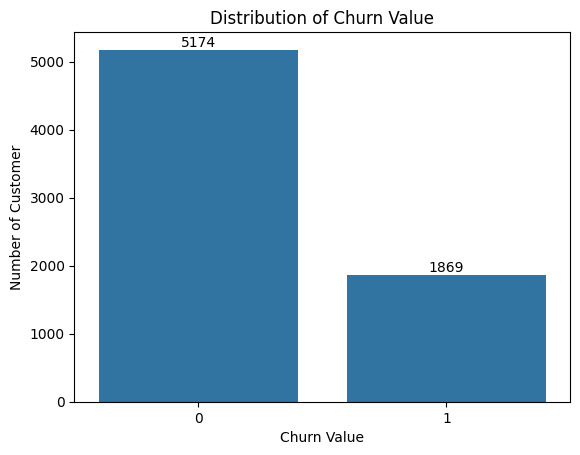

In [63]:
# Create a bar chart for the churn value column
ax = sns.countplot(data=df, x='Churn Value')
ax.bar_label(ax.containers[0])

# Add a title and labels for the x and y axes
plt.title('Distribution of Churn Value')
plt.xlabel('Churn Value')
plt.ylabel('Number of Customer')

# Show the plot
plt.show()

Observation:

*   The target variable exhibits a noticeable class imbalance, with approximately 73.47% of customer not churning and 26.53% of customers churning. This imbalance could affect model performance, particularly for models that assume or perform better with balanced classes. Therefore, special techniques such as resampling, using different performance metrics, or employing algorithms that handle imbalanced data well (e.g., ensemble methods) might be necessary.

*   The churn rate (26.53%) is a critical metric for the business. A relative high churn rate indicates a significant portion of customers are leaving, which can impact revenue and customer lifetime value. This suggest the need for further investigation into factors contributing to churn and developing strategies to improve customer retention, which could involve customer segmentation to identify distinct groups with varying churn risks and tailor intervention accordingly.

##### Task **3.2.1.2: Analysing Predictor Variables**

In [64]:
# Identify categorical data
cat = df.select_dtypes(include=['object']).keys().tolist()
print('Categorical variables', cat)

# Identify continuous data
con = df.select_dtypes(include=['float64']).keys().tolist()
print('Continuous variables:', con)

# Identify discrete data
dis = df.select_dtypes(include=['int64']).keys().tolist()
dis.remove('Churn Value')
print('Discrete variables:', dis)

Categorical variables ['Offer', 'Multiple Lines', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Gender', 'Married', 'Region']
Continuous variables: ['Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue']
Discrete variables: ['Satisfaction Score', 'Number of Referrals', 'Tenure in Months', 'Age', 'Number of Dependents']


###### **Task 3.2.1.2.1: Categorical Variables**

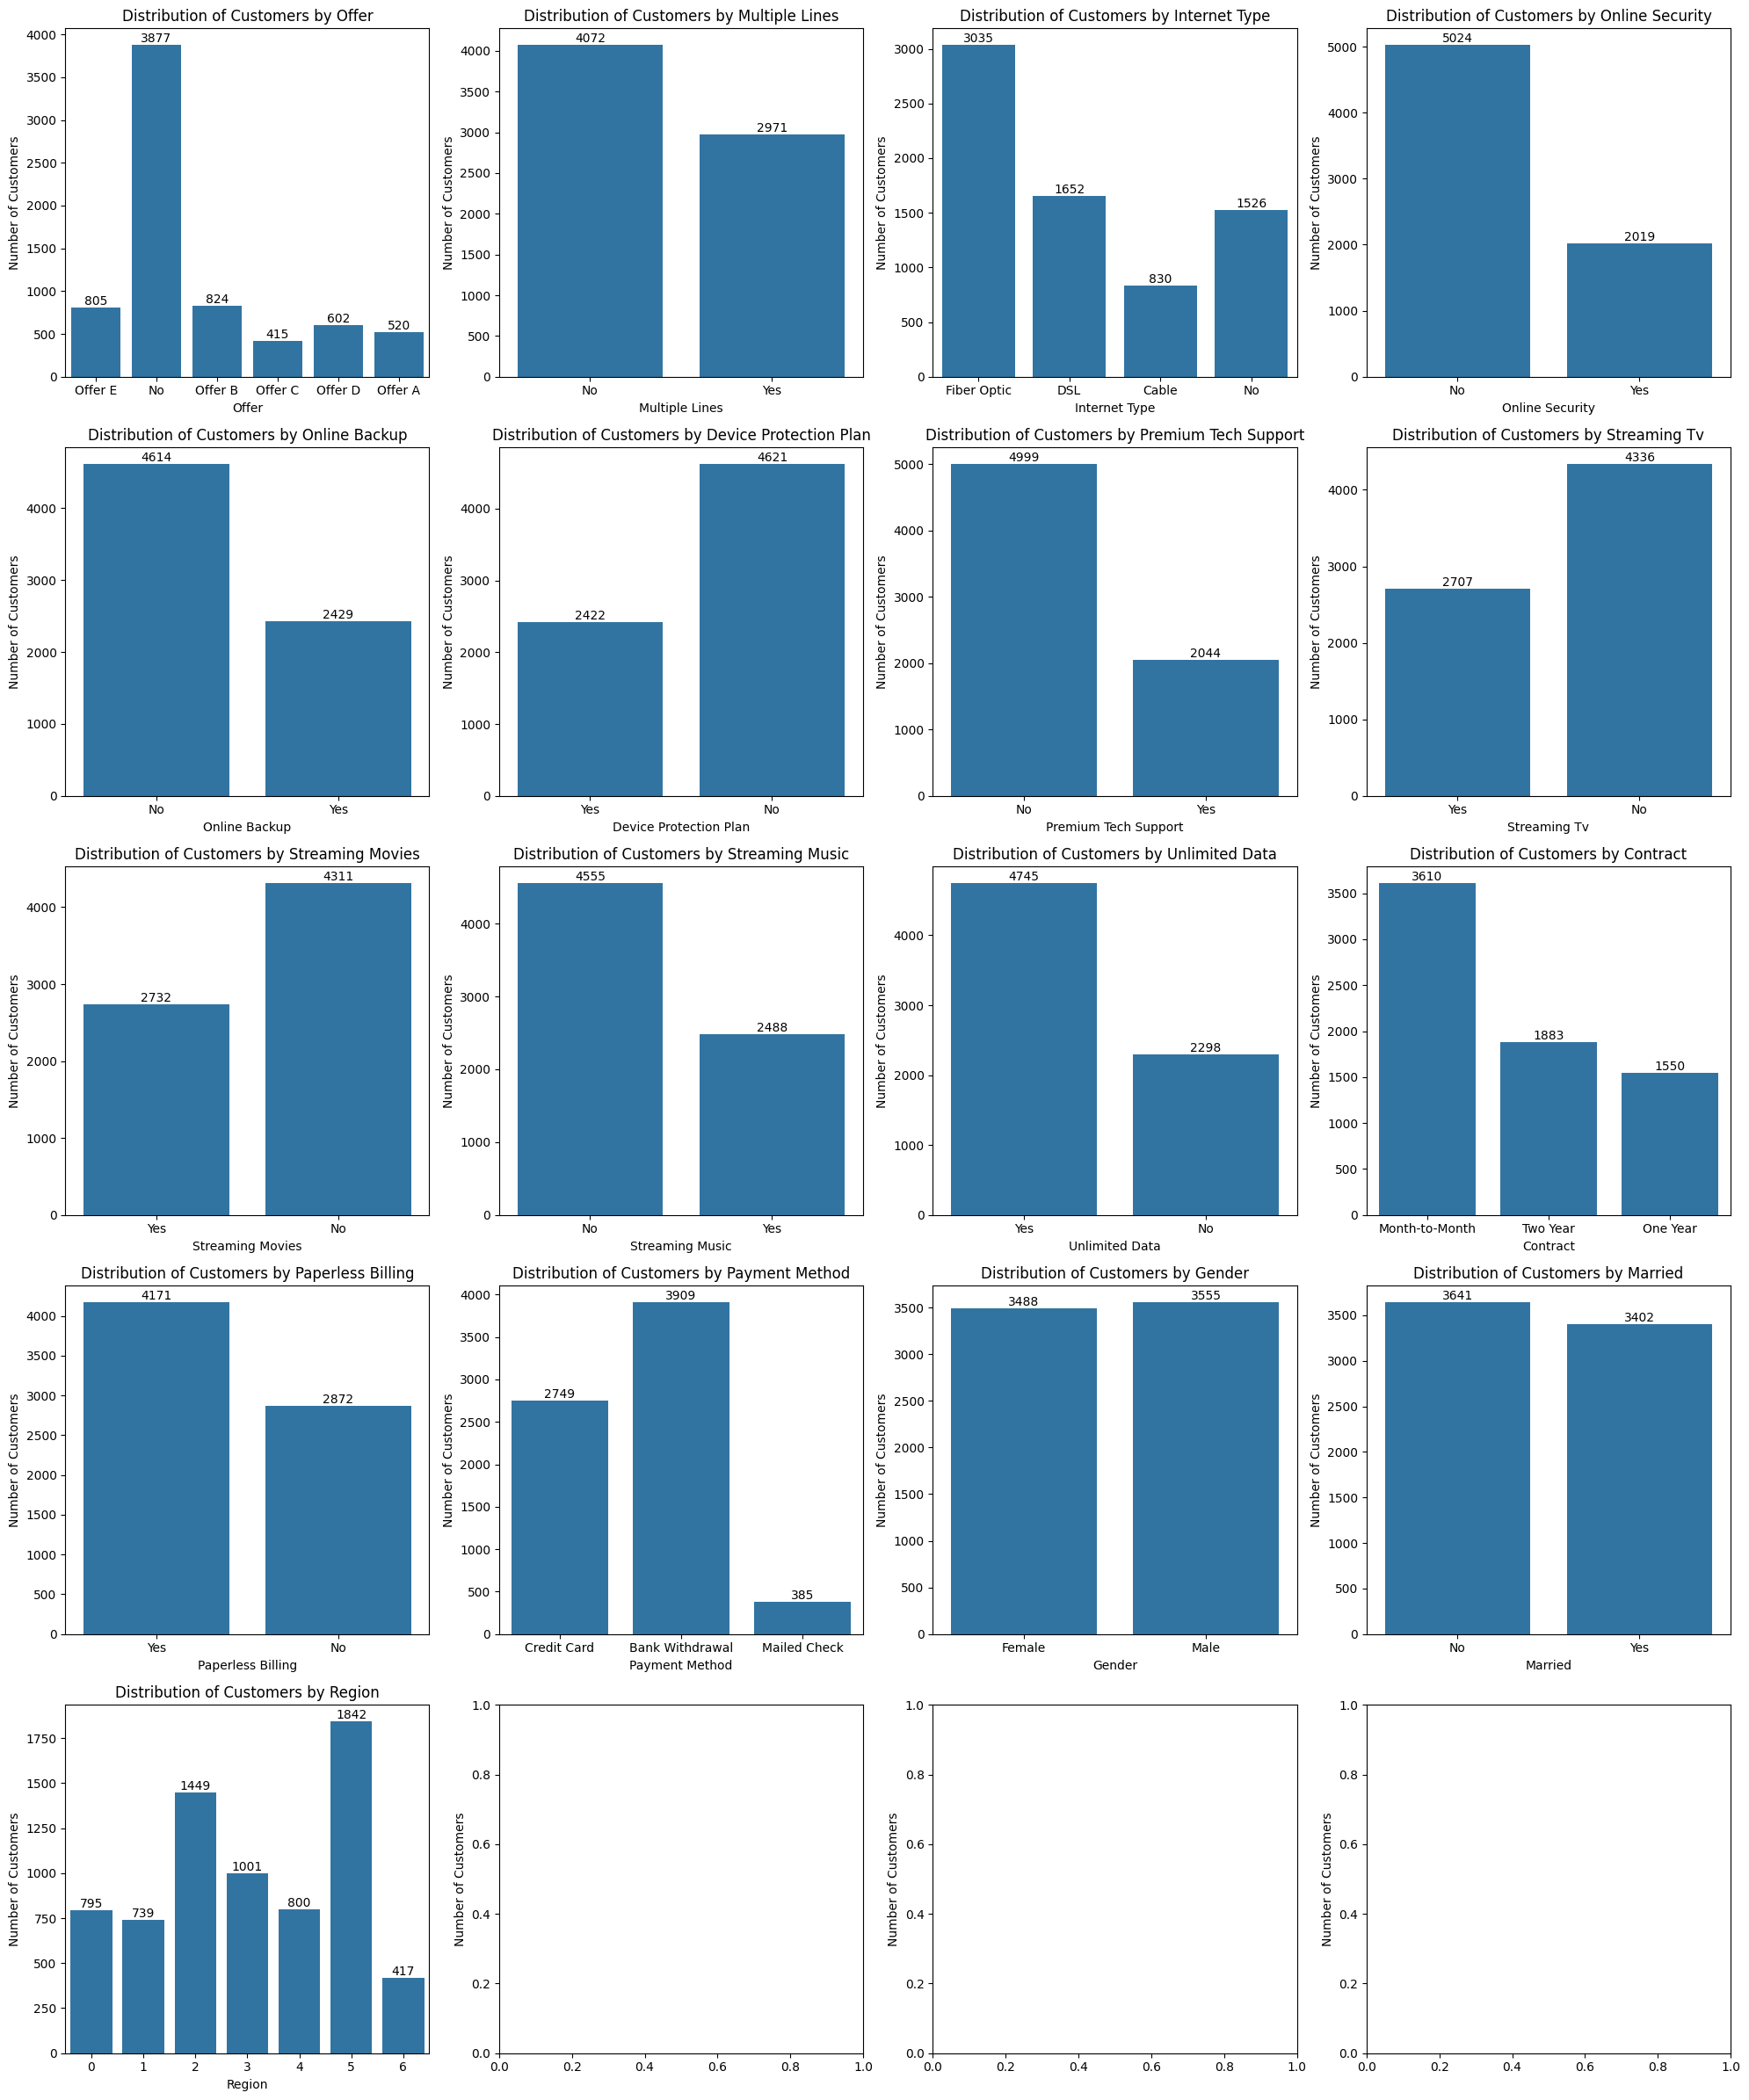

In [65]:
# Calculate the number of rows and columns needed for the subplots
n_rows = int(np.ceil(len(cat) / 4))
n_cols = 4

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 24))

# Flatten the array of subplots into a list
axs = axs.flatten()

# Create a bar chart for each categorical column
for i, col in enumerate(cat):
    ax = sns.countplot(data=df, x=col, ax=axs[i])
    ax.bar_label(ax.containers[0])

# Add a title and labels for the x and y axes
for i, ax in enumerate(axs):
    if i < len(cat):
      ax.set_title('Distribution of Customers by ' + str(cat[i].title()))
      ax.set_xlabel(cat[i].title())
    ax.set_ylabel('Number of Customers')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

###### **Task 3.2.1.2.2: Numerical Variables**

In [66]:
# Generate descriptive statistics
df.describe()

,Satisfaction Score,Churn Value,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Age,Number of Dependents
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,3.244924,0.265370,1.951867,32.386767,22.958954,20.515405,64.761692,2280.381264,1.962182,6.860713,749.099262,3034.379056,46.509726,0.468692
std,1.201657,0.441561,3.001199,24.542061,15.448113,20.418940,30.090047,2266.220462,7.902614,25.104978,846.660055,2865.204542,16.750352,0.962802
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000,19.000000,0.000000
25%,3.000000,0.000000,0.000000,9.000000,9.210000,3.000000,35.500000,400.150000,0.000000,0.000000,70.545000,605.610000,32.000000,0.000000
50%,3.000000,0.000000,0.000000,29.000000,22.890000,17.000000,70.350000,1394.550000,0.000000,0.000000,401.440000,2108.640000,46.000000,0.000000
75%,4.000000,1.000000,3.000000,55.000000,36.395000,27.000000,89.850000,3786.600000,0.000000,0.000000,1191.100000,4801.145000,60.000000,0.000000
max,5.000000,1.000000,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,80.000000,9.000000


**Continuous Variables**

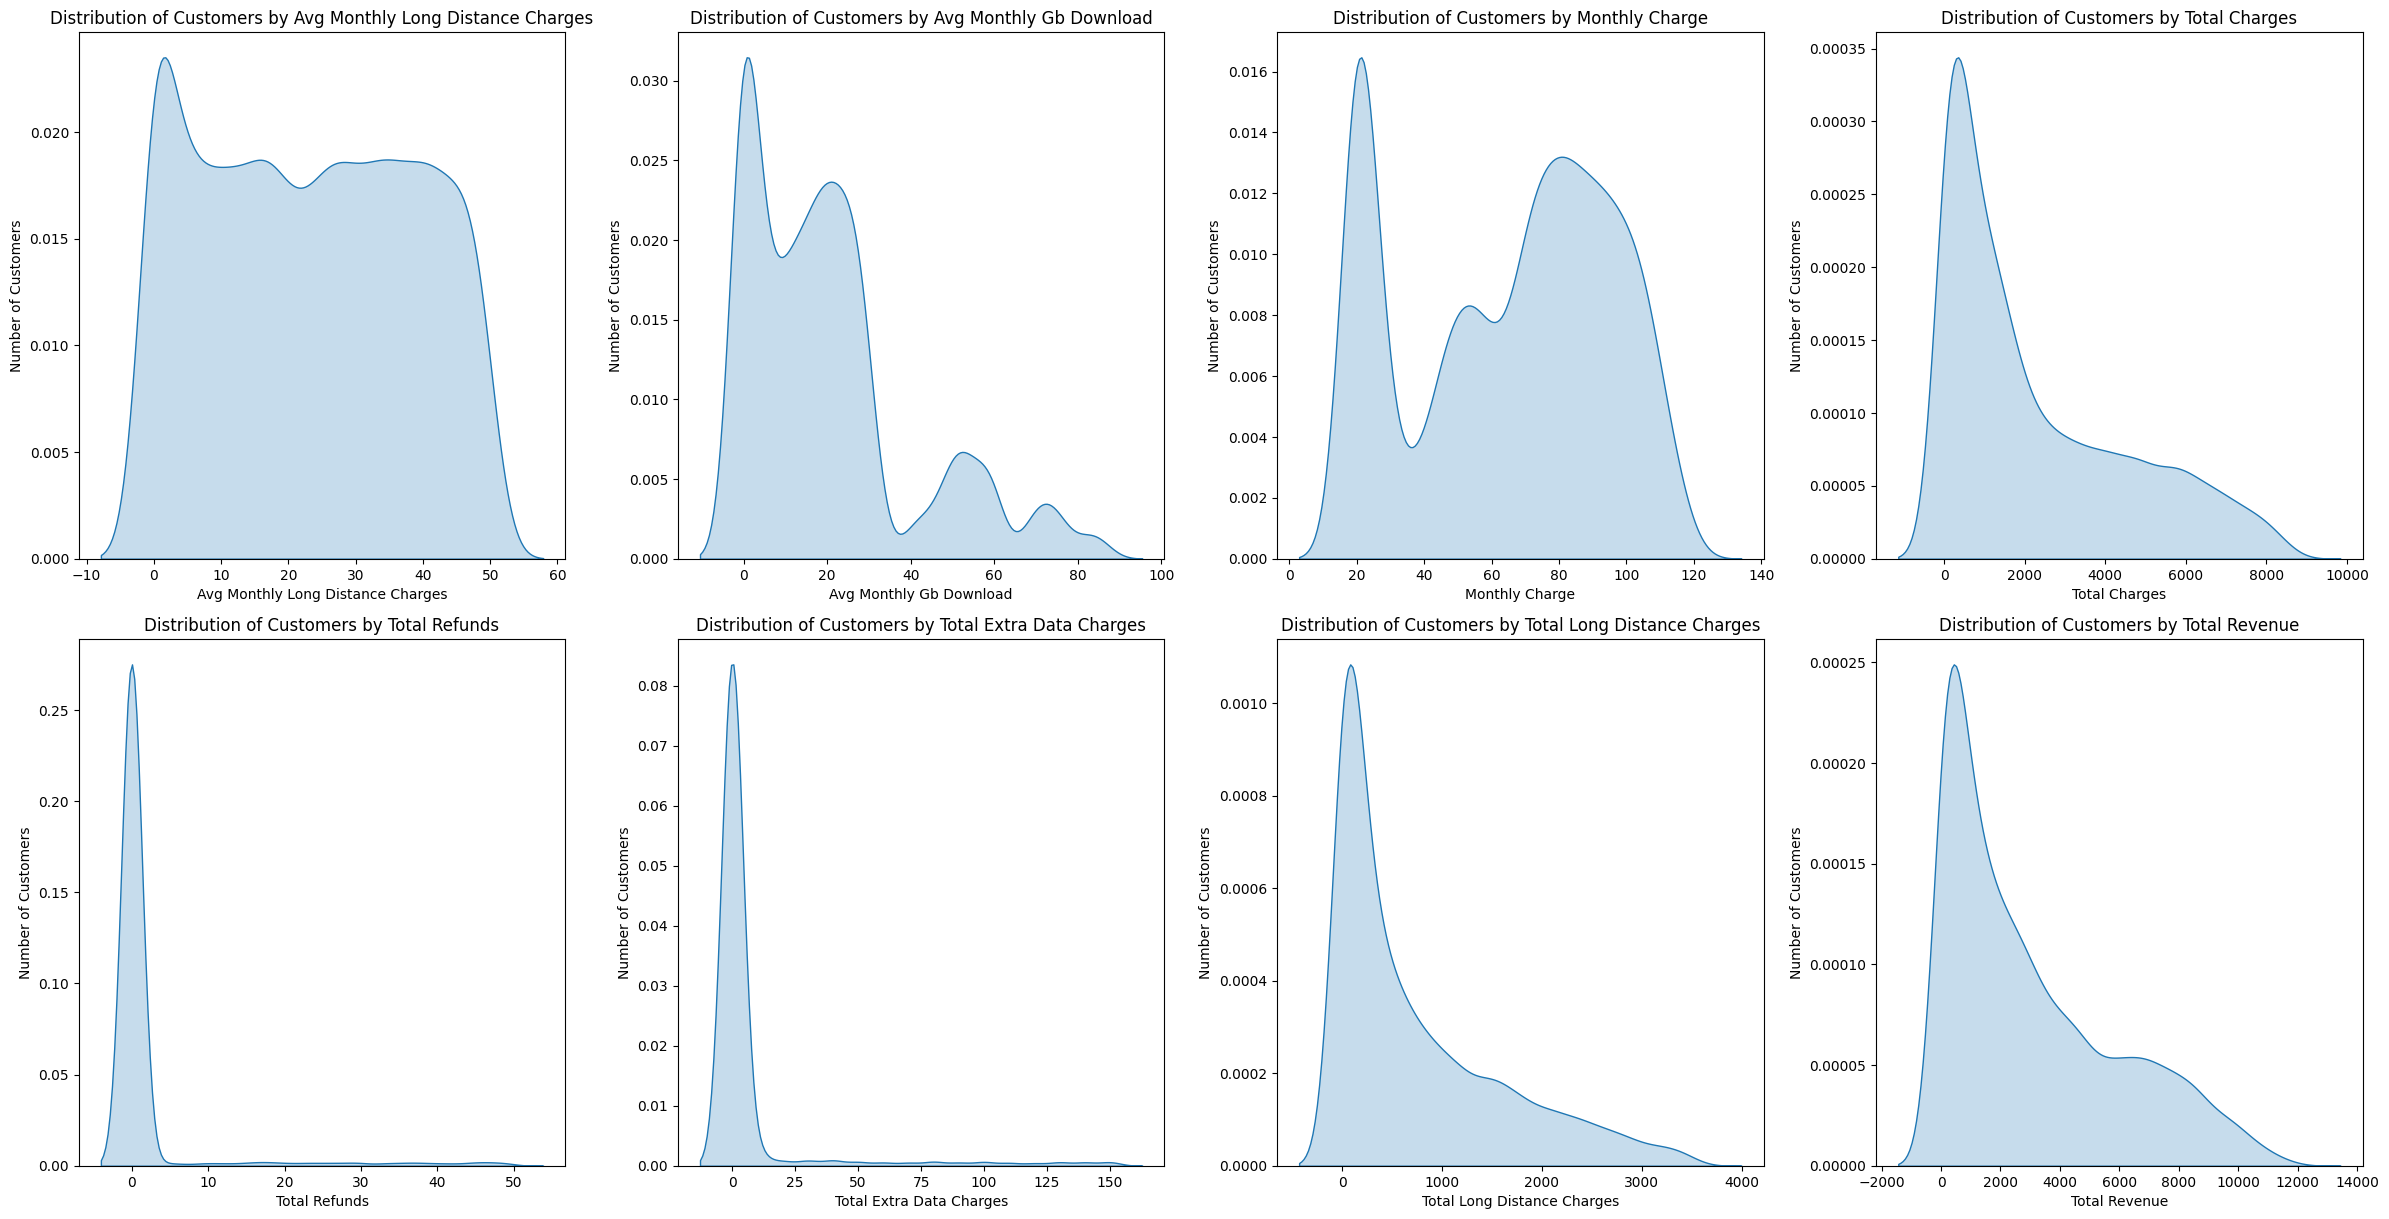

In [67]:
# Set the figure size
plt.figure(figsize=(24, 24))

# Loop over the columns and create a kde for each one
for i, col in enumerate(con):
    plt.subplot(4, 4, i+1)
    sns.kdeplot(data=df, x=col, fill=True)
    plt.title('Distribution of Customers by ' + str(con[i].title()))
    plt.xlabel(str(con[i].title()))
    plt.ylabel('Number of Customers')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

**Discrete Variables**

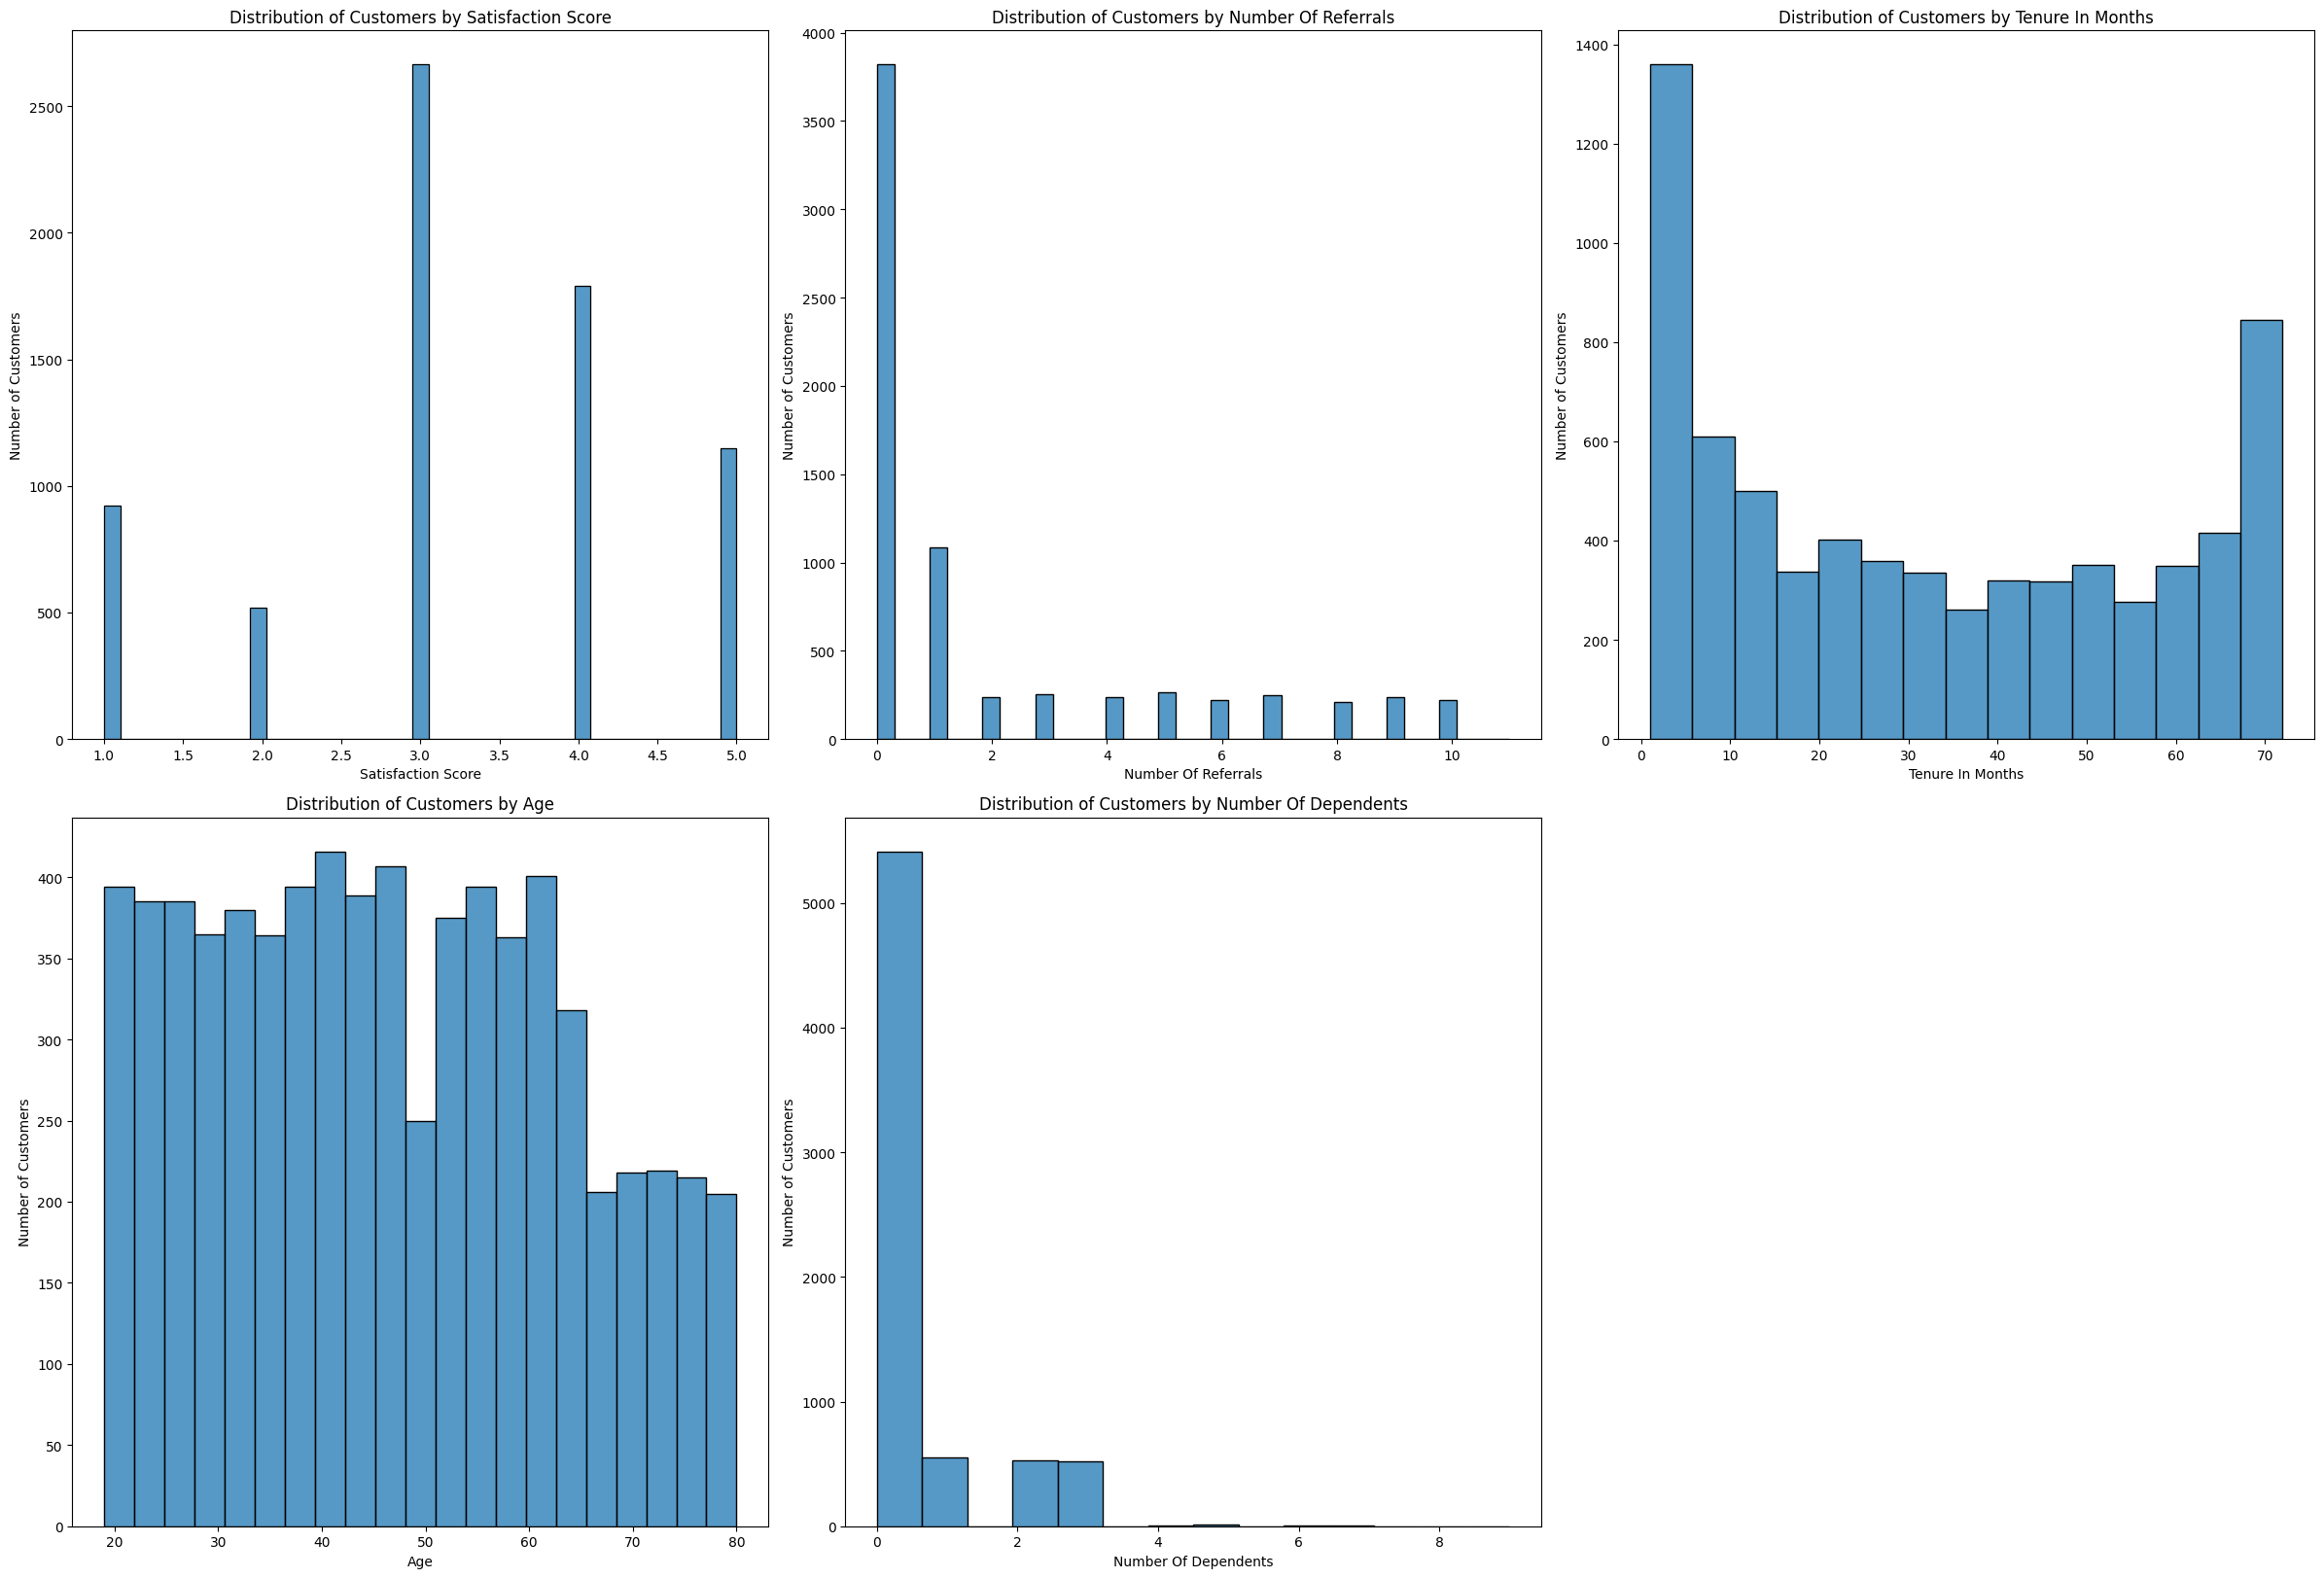

In [68]:
# Set the figure size
plt.figure(figsize=(24, 24))

# Loop over the columns and create a histogram for each one
for i, col in enumerate(dis):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=col)
    plt.title('Distribution of Customers by ' + str(dis[i].title()))
    plt.xlabel(str(dis[i].title()))
    plt.ylabel('Number of Customers')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

### **Task 3.2: Bivariate EDA**

#### **Task 3.2.1: Analysing Categorical Variables by Churn Value**

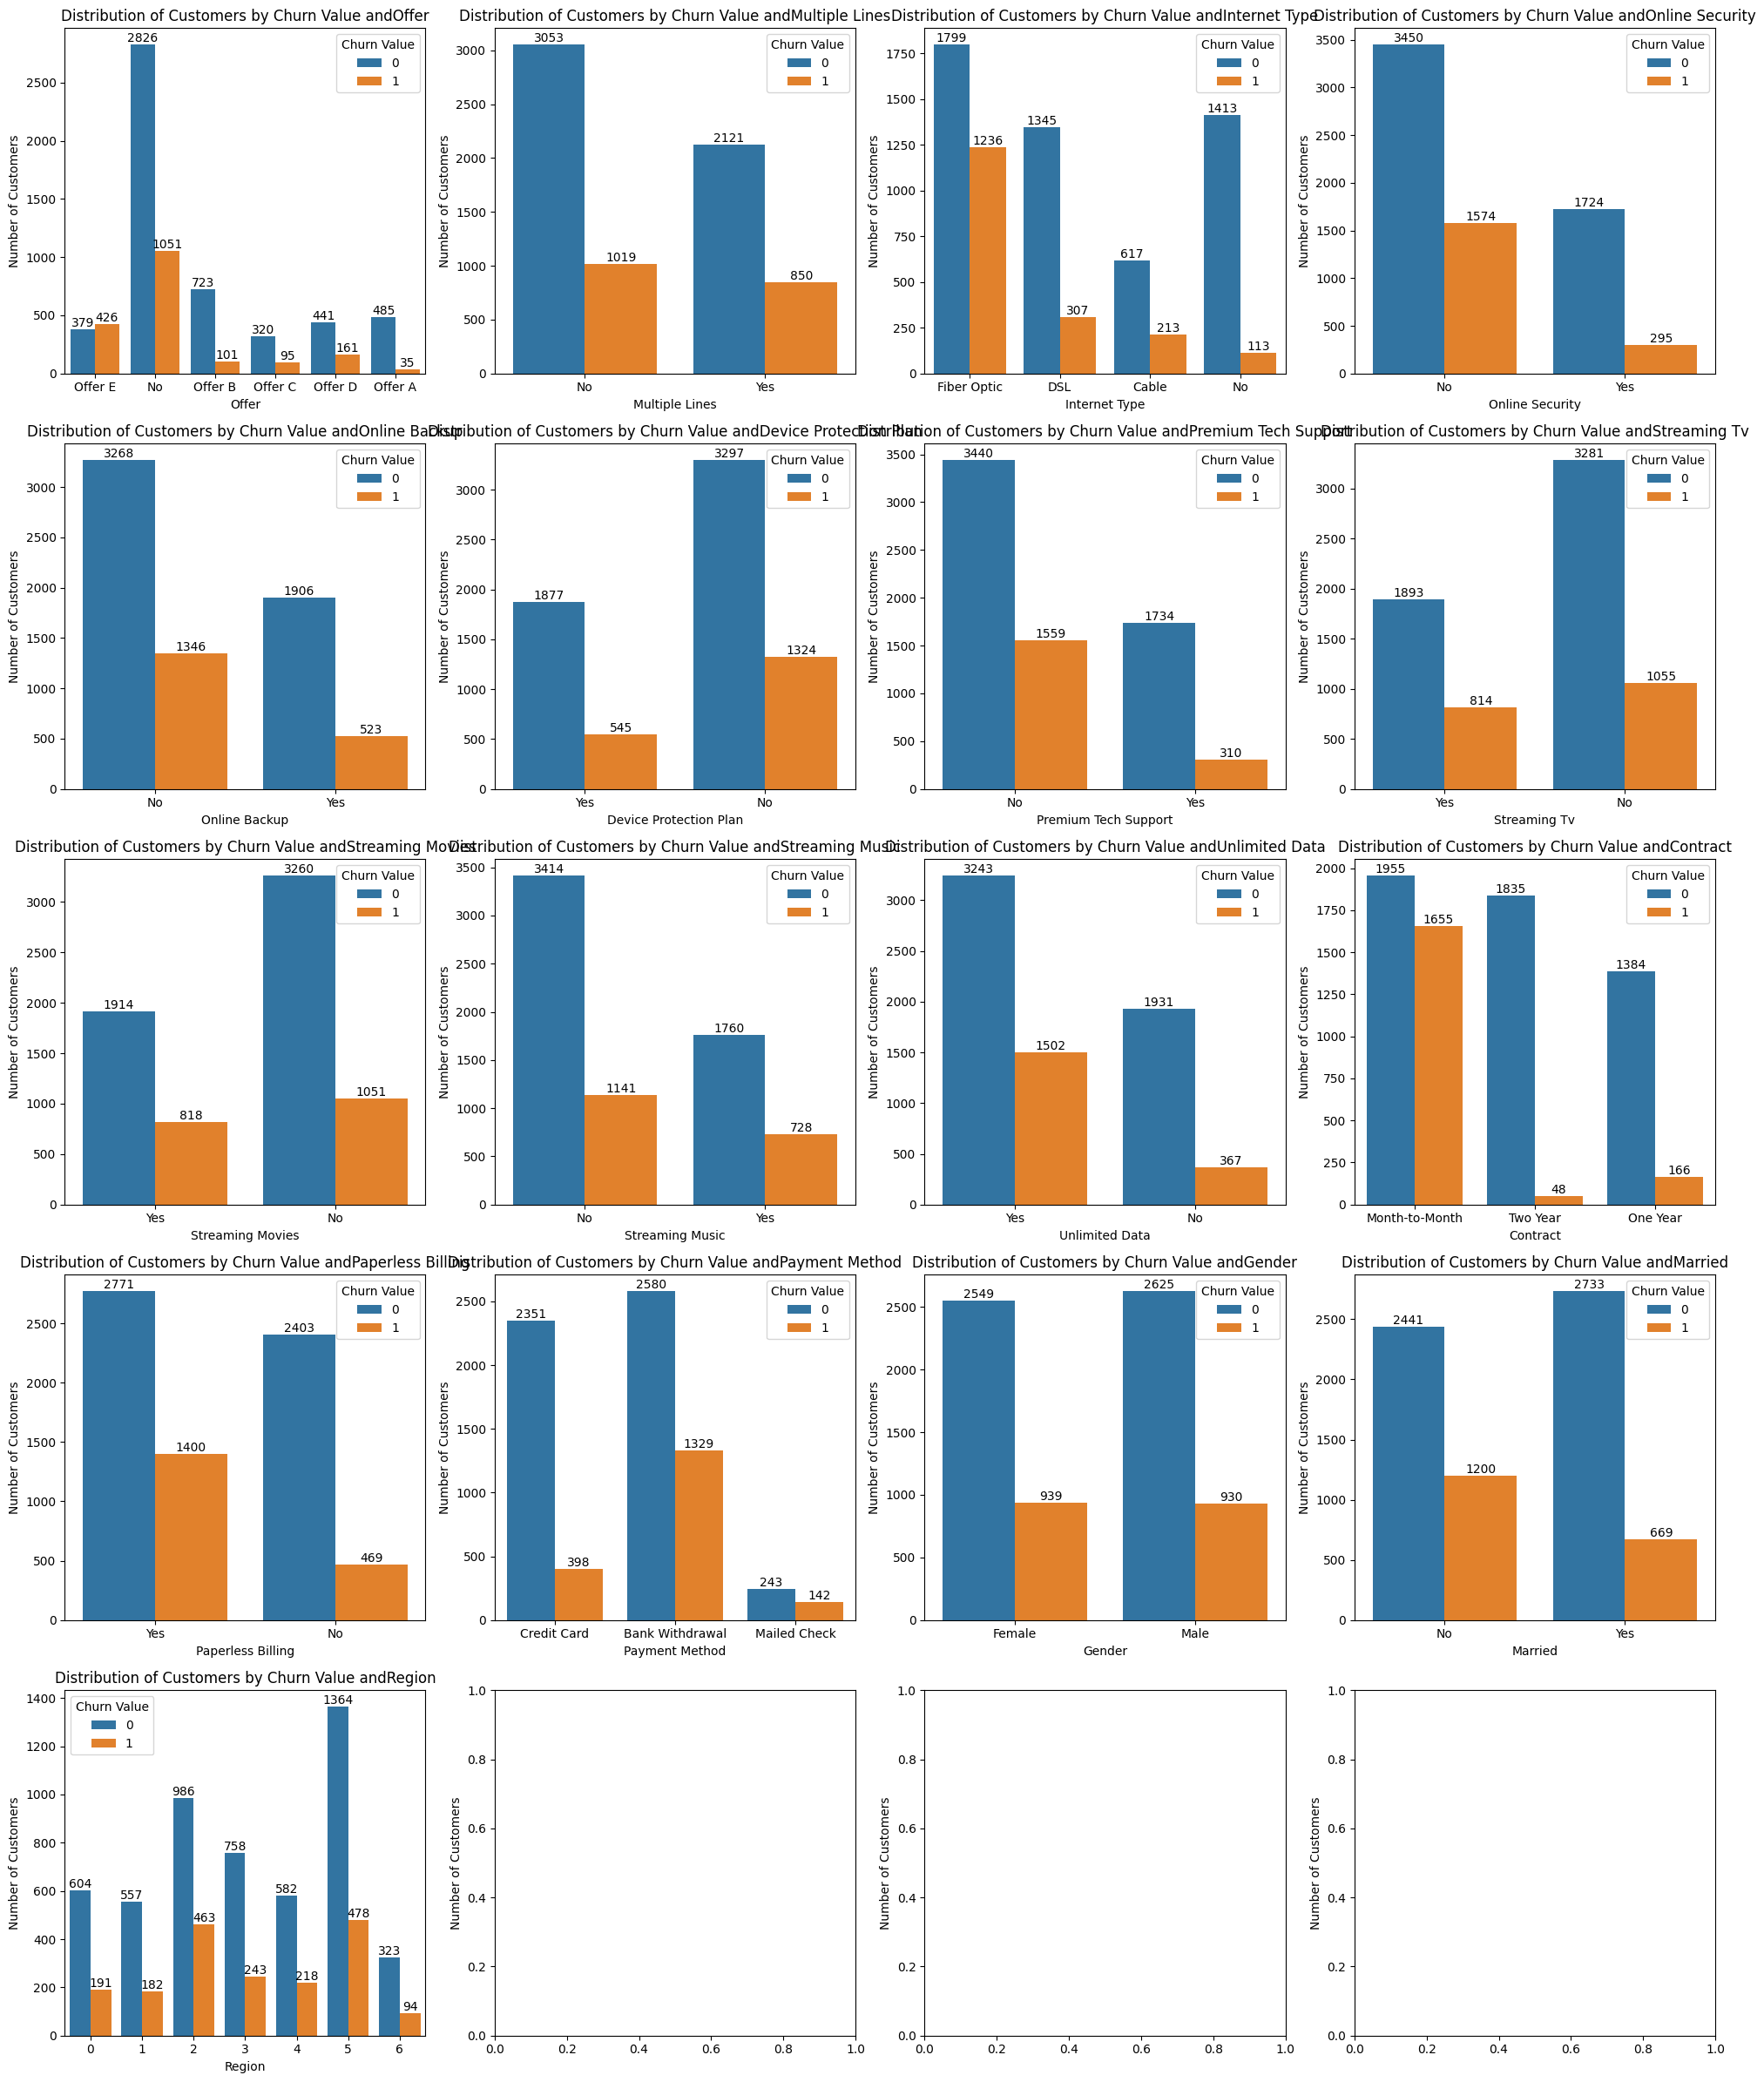

In [69]:
# Calculate the number of rows and columns needed for the subplots
n_rows = int(np.ceil(len(cat) / 4))
n_cols = 4

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 24))

# Flatten the array of subplots into a list
axs = axs.flatten()

# Create a bar chart for each categorical column
for i, col in enumerate(cat):
    ax = sns.countplot(data=df, x=col, hue='Churn Value', ax=axs[i])
    for i in ax.containers:
      ax.bar_label(i,)

# Add a title and labels for the x and y axes
for i, ax in enumerate(axs):
    if i < len(cat):
      ax.set_title('Distribution of Customers by Churn Value and' + str(cat[i].title()))
      ax.set_xlabel(cat[i].title())
    ax.set_ylabel('Number of Customers')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

#### **Task 3.2.2: Analysing Continuous Variables by Churn Value**

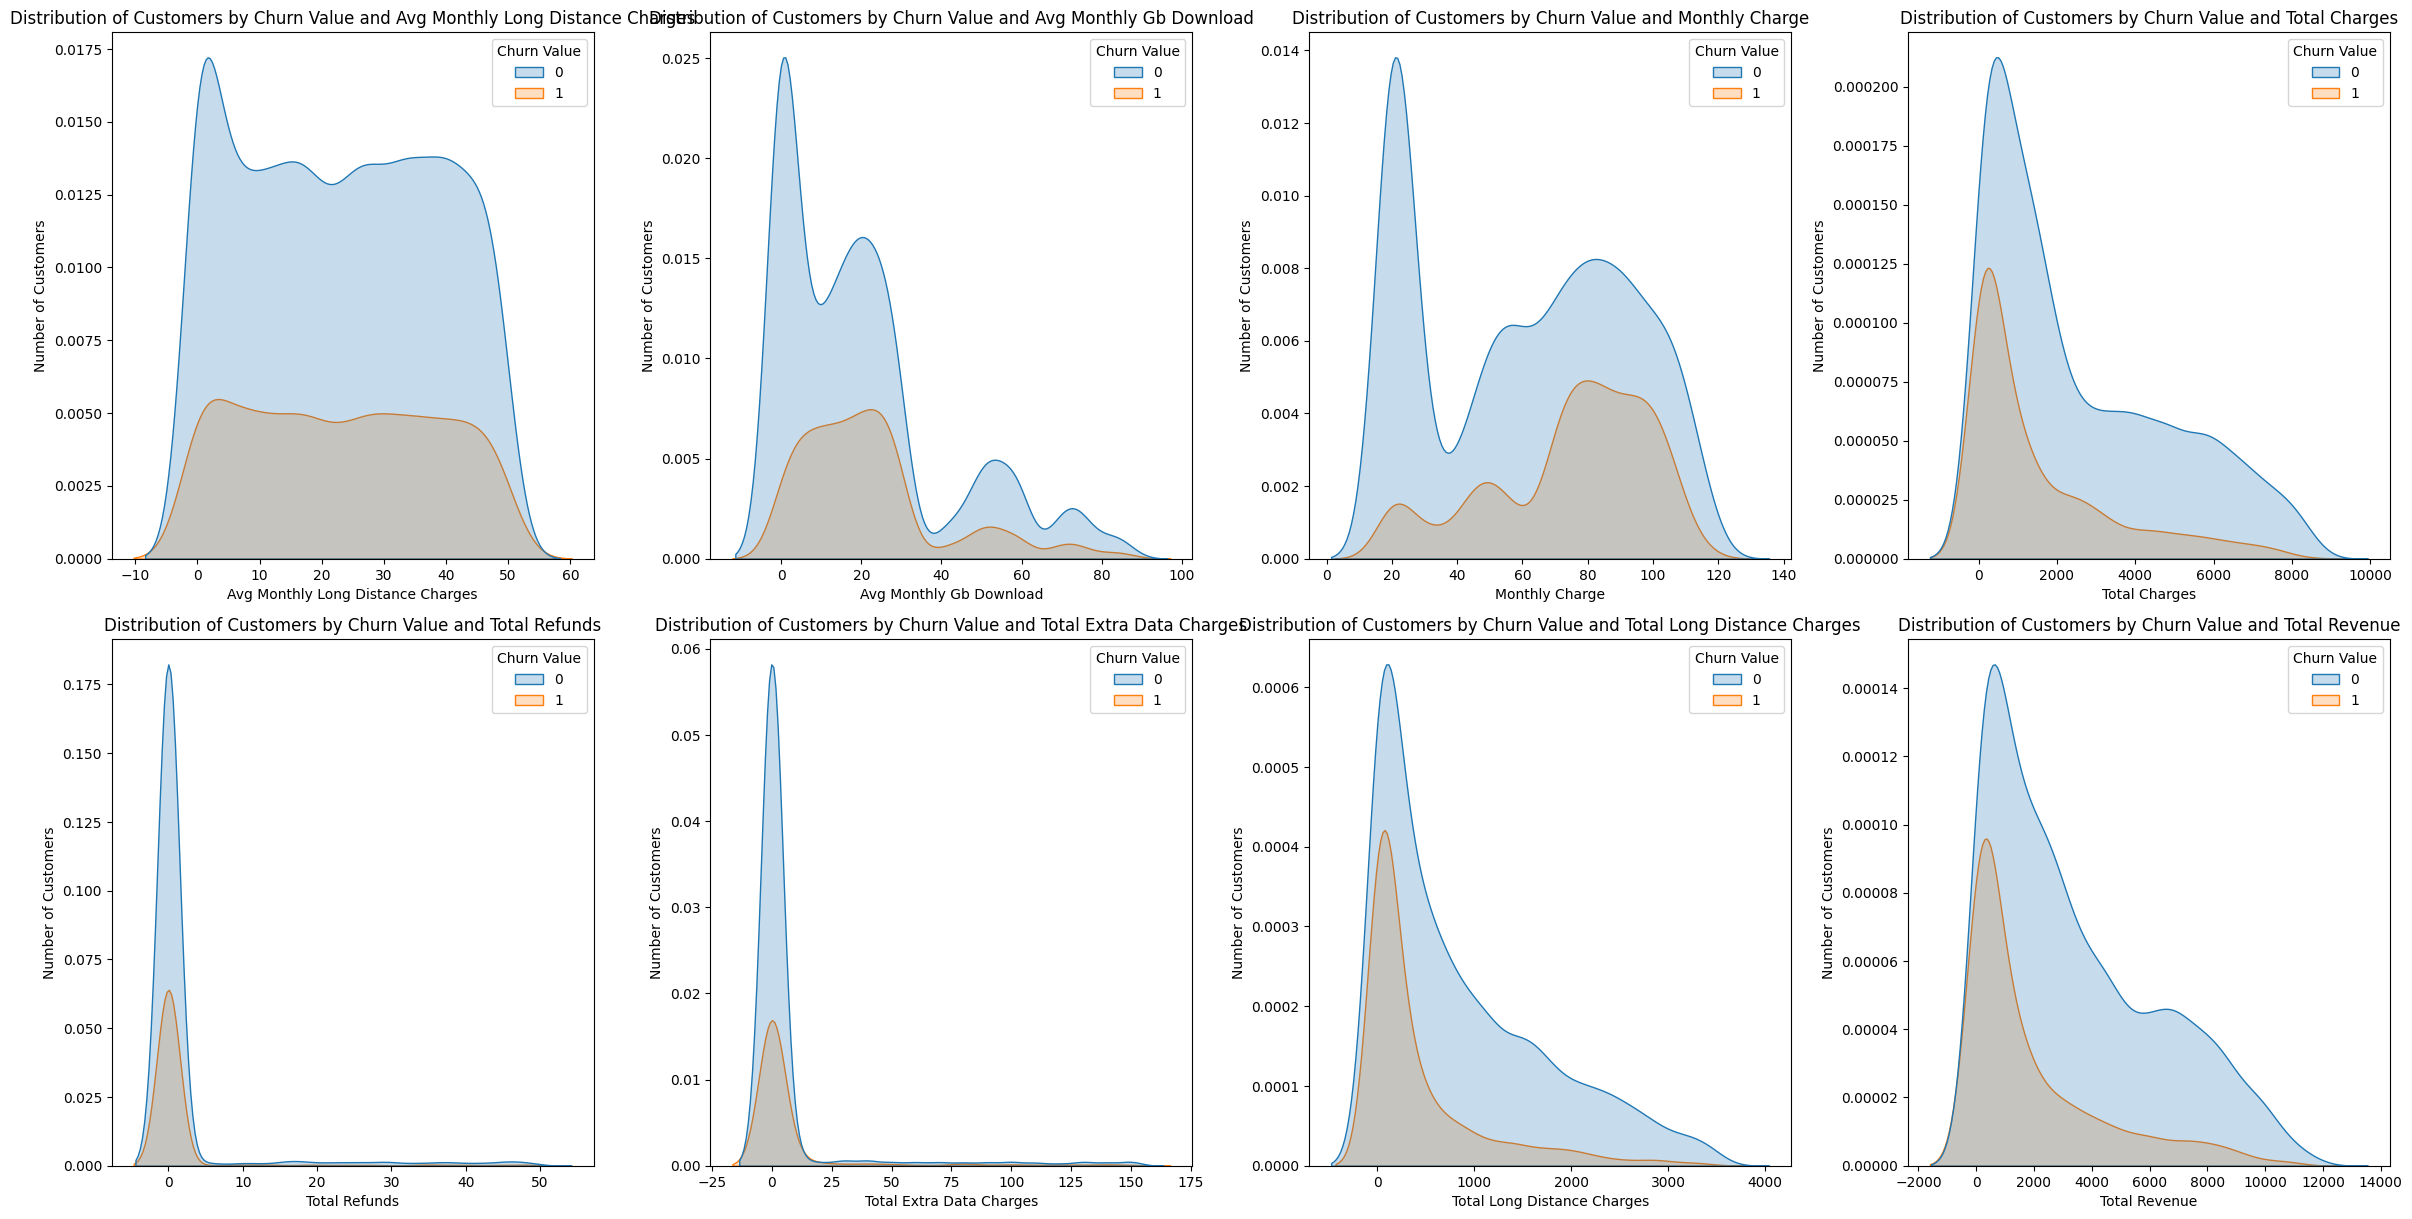

In [70]:
# Set the figure size
plt.figure(figsize=(24, 24))

# Loop over the columns and create a kde for each one
for i, col in enumerate(con):
    plt.subplot(4, 4, i+1)
    sns.kdeplot(data=df, x=col, hue='Churn Value', fill=True)
    plt.title('Distribution of Customers by Churn Value and ' + str(con[i].title()))
    plt.xlabel(str(con[i].title()))
    plt.ylabel('Number of Customers')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

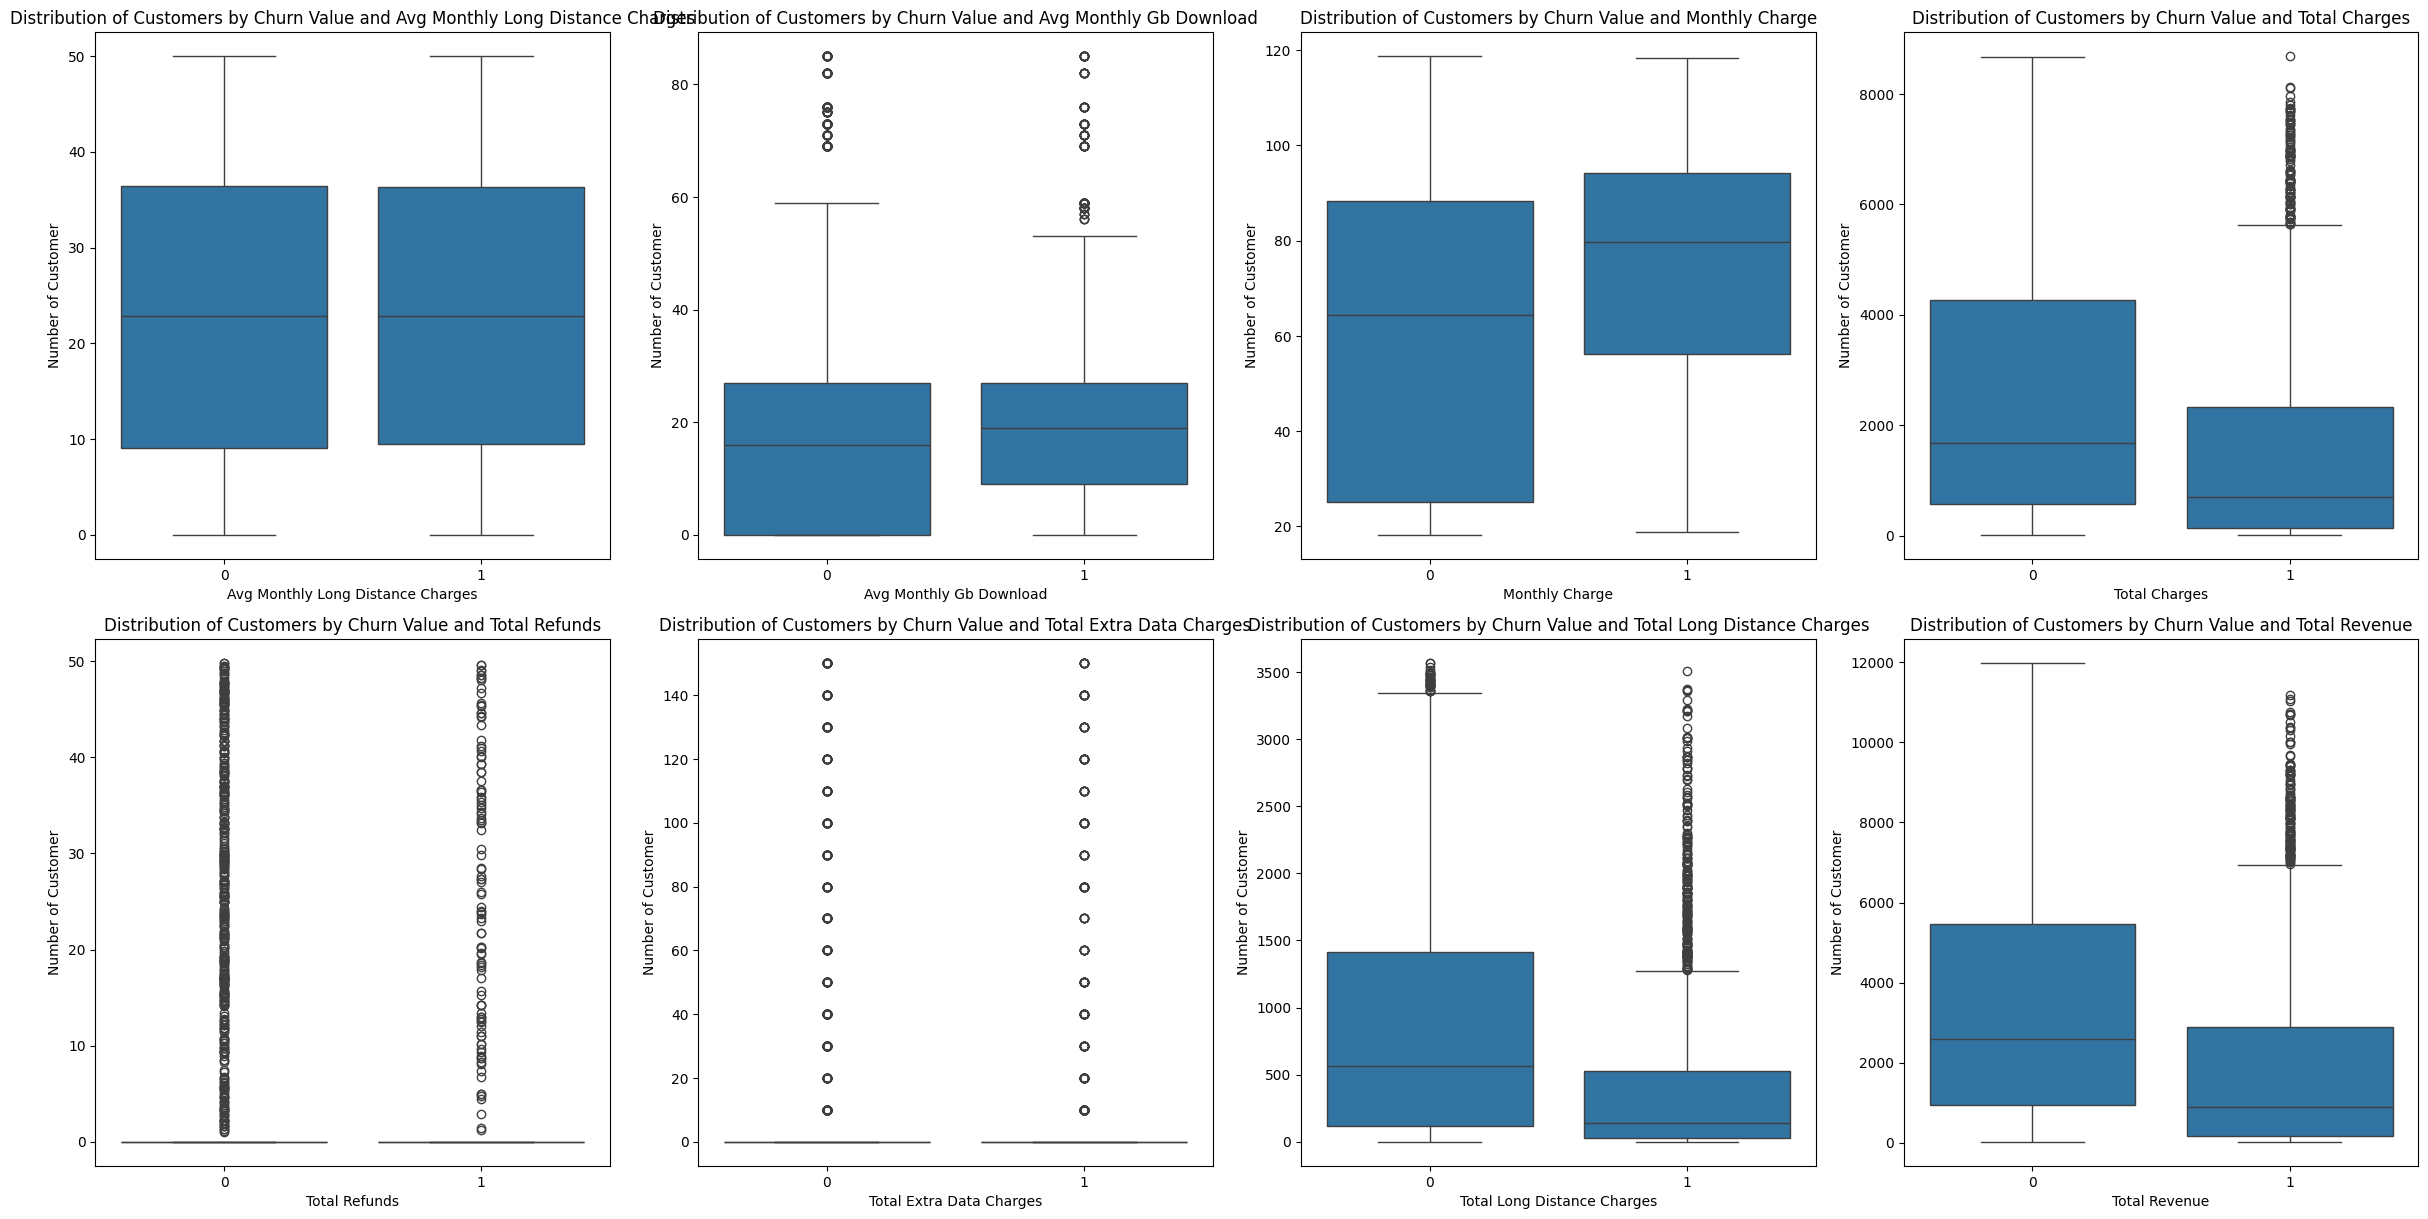

In [71]:
# Set the figure size
plt.figure(figsize=(24, 24))

# Loop over the columns and create a kde for each one
for i, col in enumerate(con):
    plt.subplot(4, 4, i+1)
    sns.boxplot(data=df, x='Churn Value', y=col)
    plt.title('Distribution of Customers by Churn Value and ' + str(con[i].title()))
    plt.xlabel(str(con[i].title()))
    plt.ylabel('Number of Customer')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

#### **Task 3.2.3: Analysing Discrete Variables by Churn Value**

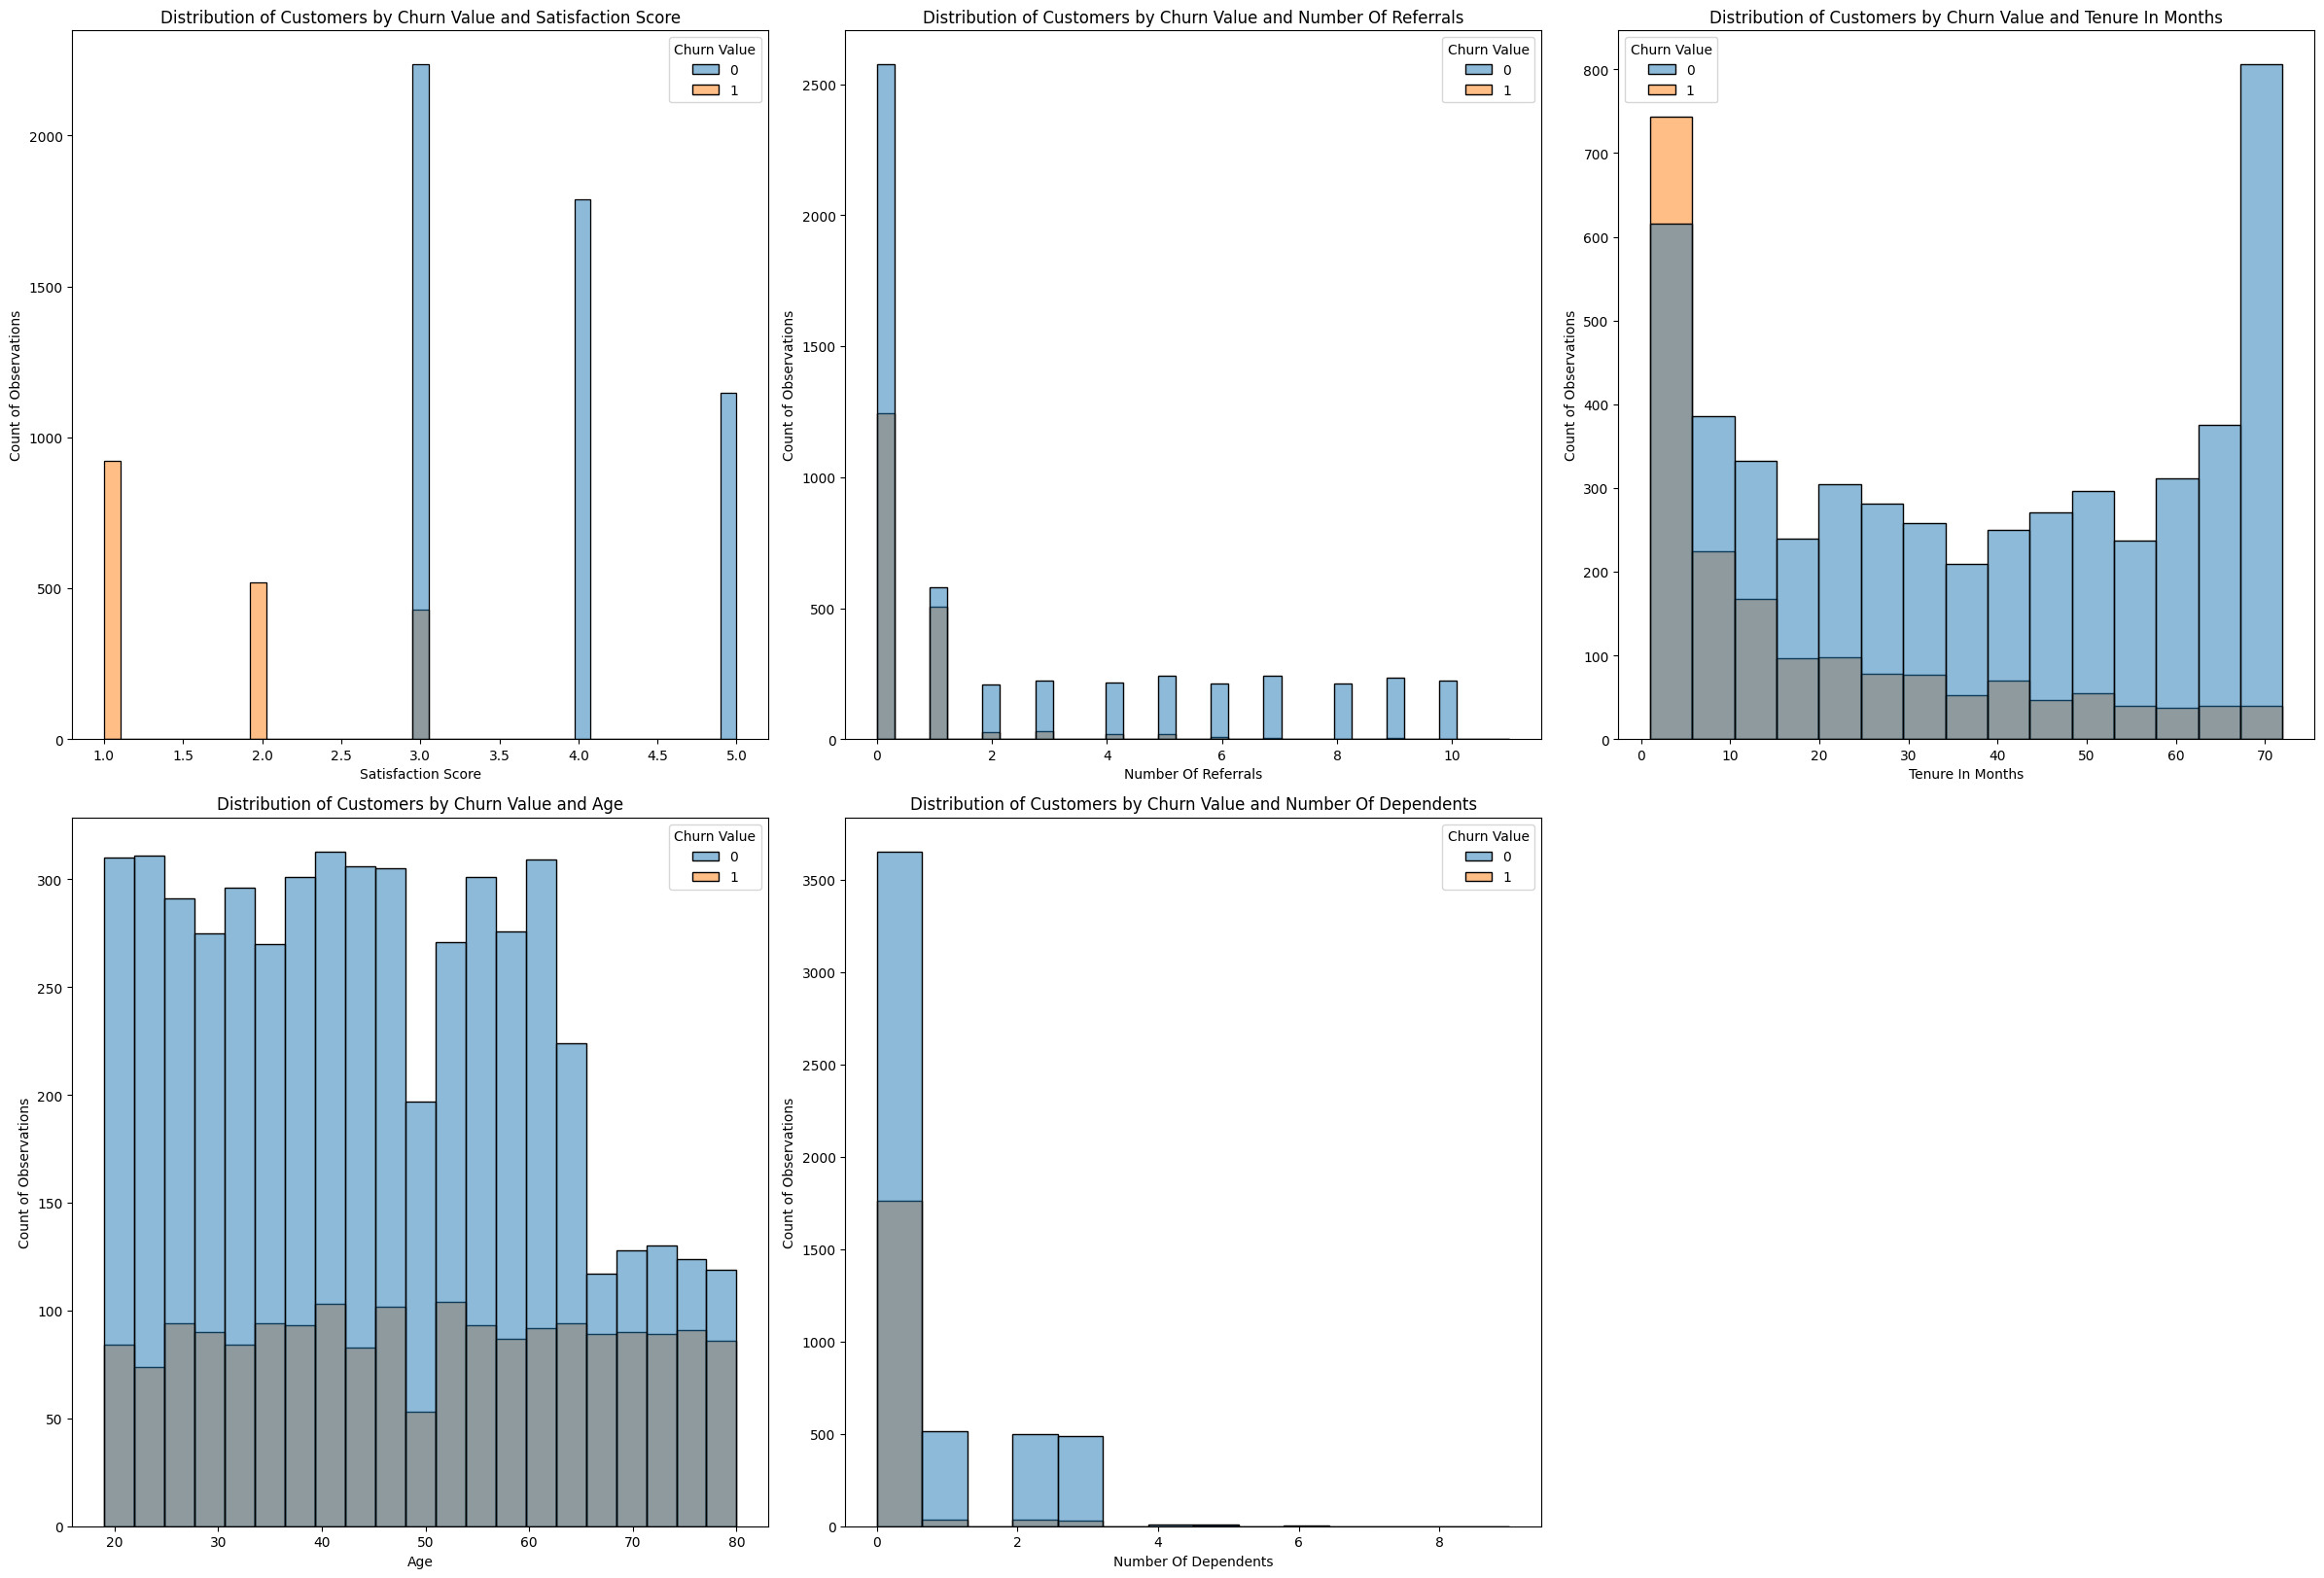

In [72]:
# Set the figure size
plt.figure(figsize=(24, 24))

# Loop over the columns and create a histogram for each one
for i, col in enumerate(dis):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=col, hue='Churn Value')
    plt.title('Distribution of Customers by Churn Value and ' + str(dis[i].title()))
    plt.xlabel(str(dis[i].title()))
    plt.ylabel('Count of Observations')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

## **Task 4: Data Preparation (Cont.)**

### **Task 4.1: Chi Square Test (Categorical Input vs. Categorical Target)**

In [73]:
def chi_square(df, categorical_vars, target_var):
    """
    Calculate the chi-square statistic, p-value, degrees of freedom,
    and decide whether the association is statistically significant.

    Parameters:
    - df: DataFrame containing the data.
    - categorical_vars: List of categorical variable names.
    - target_var: Name of the target variable.

    Returns:
    - A DataFrame containing the chi-square statistic, p-value, degrees of freedom,
      and decision to reject the null hypothesis for each categorical variable.
    """
    chi_square_results = []
    significance_level = 0.05  # Standard significance level

    for var in categorical_vars:
        # Create contingency table (crosstab) between the variable and the target
        contingency_table = pd.crosstab(df[var], df[target_var])

        # Perform chi-square test
        chi2, p_value, dof, _ = chi2_contingency(contingency_table)

        # Determine whether the association is statistically significant
        statistically_significant = p_value <= significance_level

        # Store results in DataFrame
        chi_square_results.append({
            'Variable': var,
            'Chi-square': chi2,
            'P-value': p_value,
            'Degrees of Freedom': dof,
            'Statistically Significant': statistically_significant
        })

    return pd.DataFrame(chi_square_results)

In [74]:
# Call the chi_square function
chi_square_results = chi_square(df, cat, 'Churn Value')

# Print the results
chi_square_results

,Variable,Chi-square,P-value,Degrees of Freedom,Statistically Significant
0,Offer,481.725489,7.020357e-102,5,True
1,Multiple Lines,11.143251,8.433795e-04,1,True
2,Internet Type,653.832054,2.150350e-141,3,True
3,Online Security,205.633104,1.232098e-46,1,True
4,Online Backup,47.260854,6.214093e-12,1,True
5,Device Protection Plan,30.513395,3.315693e-08,1,True
6,Premium Tech Support,190.166842,2.923567e-43,1,True
7,Streaming TV,27.862522,1.302484e-07,1,True
8,Streaming Movies,26.251336,2.997474e-07,1,True
9,Streaming Music,14.421460,1.461276e-04,1,True


Observation:

*   The `Gender` columns have p-values greater than the significance level of 0.05, indicating no statitically significant association with the target variable, suggesting that this variable do not contribute significantly to predicting the target variable. Therefore, theis column will be removed to simplify the model and ruduce niose and multicollinearity, potentially improving its performance.

In [75]:
# Drop the 'Phone Service' and 'Gender' columns
print("Number of columns before dropping the 'Gender' columns:", df.shape[1])
df = df.drop(columns=['Gender'], axis=1)
print("Number of columns after dropping the 'Gender' columns:", df.shape[1])

Number of columns before dropping the 'Gender' columns: 31
Number of columns after dropping the 'Gender' columns: 30


### **Task 4.2: ANOVA (Continuous Input vs. Categorical Target)**

In [76]:
def anova_test(df, numerical_vars, target_var):
    """
    Calculate the f_statistic, p-value,
    and decide whether the association is statistically significant.

    Parameters:
    - df: DataFrame containing the data.
    - numerical_vars: List of numerical variable names.
    - target_var: Name of the categorical target variable.

    Returns:
    - A DataFrame containing the ANOVA F-statistic, p-value,
      and decision to reject the null hypothesis for each numerical variables.
    """
    anova_results = []
    significance_level = 0.05  # Standard significance level

    for var in numerical_vars:

        # Perform ANOVA
        f_statistic, p_value = f_oneway(df[var], df[target_var])

        # Determine whether the association is statistically significant
        statistically_significant = p_value <= significance_level

        # Store results in DataFrame
        anova_results.append({
            'Variable': var,
            'F-statistic': f_statistic,
            'P-value': p_value,
            'Statistically Significant': statistically_significant
        })

    return pd.DataFrame(anova_results)

In [77]:
# Call the anova_test function
anova_test_results = anova_test(df, con+dis, 'Churn Value')

# Print the results
anova_test_results

,Variable,F-statistic,P-value,Statistically Significant
0,Avg Monthly Long Distance Charges,15186.520481,0.000000e+00,True
1,Avg Monthly GB Download,6923.725088,0.000000e+00,True
2,Monthly Charge,32351.047402,0.000000e+00,True
3,Total Charges,7129.633454,0.000000e+00,True
4,Total Refunds,323.690539,1.437182e-71,True
5,Total Extra Data Charges,485.935274,6.685750e-106,True
6,Total Long Distance Charges,5509.477500,0.000000e+00,True
7,Total Revenue,7897.872442,0.000000e+00,True
8,Satisfaction Score,38149.856107,0.000000e+00,True
9,Number of Referrals,2176.900256,0.000000e+00,True


## **Task 5: Modeling**

### **Task 5.1: Cluster Analysis - Segmenting Customer Based on Their Behaviours and Characteristics**

#### **Task 5.1.1 Modeling Technique Selection - K-Prototype**

In [81]:
# Make a copy of df's indices and data
clustering = df.copy(deep=True)

##### **Task 5.1.1.1 Separating the Predictors and the Labels**

In [82]:
# Separate the predictors and the labels
X = clustering.drop('Churn Value', axis=1)

##### **Task 5.1.1.2 Separating the Numerical and Categorical Features**

In [83]:
# Identify numeric and categorical features based on data types
num = X.select_dtypes(include=[np.number]).columns
cat = X.select_dtypes(include=[object]).columns

##### **Task 5.1.1.3 Scaling Numerical Features**

In [84]:
# Standardize numerical features
scaler = StandardScaler()
X[num] = scaler.fit_transform(X[num])

In [85]:
# Get the indices of categorical features
cat_indices = [X.columns.get_loc(col) for col in cat]

In [86]:
# Convert features to numpy array
data_array = X.to_numpy()

In [105]:
# Elbow Method to determine optiomal K
cost = []
K_range = range(2, int(np.sqrt(df.shape[1]))+1)
for n_clusters in K_range:
    kproto = KPrototypes(n_clusters=n_clusters, init='Cao', verbose=0)
    kproto.fit_predict(data_array, categorical=cat_indices)
    cost.append(kproto.cost_)

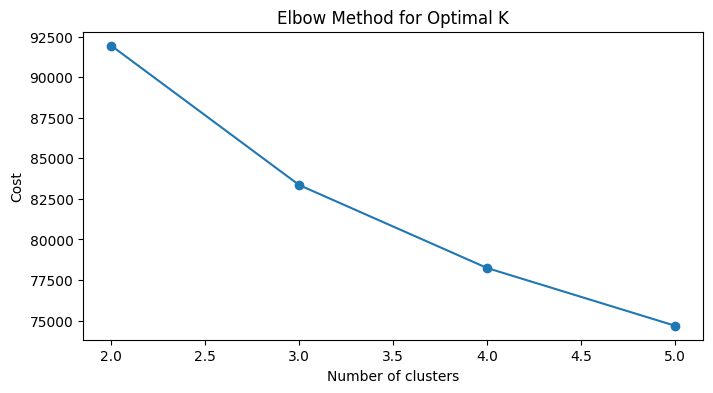

In [106]:
# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, cost, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal K')
plt.show()

In [155]:
# Calculate the differences in cost between consecutive points
cost_diff = [cost[i] - cost[i-1] for i in range(1, len(cost))]

# Print the cost values, rate of change, and relative decrease at each point
print("# Cost     Rate of Change Relative Decrease")
print("- -------- -------------- -----------------")

# Initialize variables for rate of change and relative decrease
rate_of_change = [0]  # No rate of change for the first point
relative_decrease = [0]  # No relative decrease for the first point

# Calculate rate of change and relative decrease for each point
for i in range(1, len(cost)):
    roc = cost_diff[i-1]  # Rate of change
    rd = cost_diff[i-1] / cost[i-1]  # Relative decrease
    rate_of_change.append(roc)
    relative_decrease.append(rd)

# Print the metrics for each point
for k, c, roc, rd in zip(K_range, cost, rate_of_change, relative_decrease):
    print(f"{k} {c:8.2f}  {roc:13.2f}  {rd:16.2f}")

# Cost     Rate of Change Relative Decrease
- -------- -------------- -----------------
2 91947.96           0.00              0.00
3 83353.70       -8594.26             -0.09
4 78238.79       -5114.91             -0.06
5 74678.41       -3560.38             -0.05


Observation:

*   It can be seen that the cost decreases as the number of clusters increases, which is expected. However, it is important to look for a point where the decrease in cost becomes less significant or starts to flatten out. The rate of decrease in cost slows down as the number of clusters increases. The cost decreases significantly when moving from k=2 to k=3, indicating a substantial improvement in clustering performance. After k=3, the decrease in cos becomes less significant, with smaller rate of change and relative decrease values, suggesting diminishing returns in clustering performance. Therefore, k=3 appears to be a reasonable choice for the optimal number of clusters.

#### **Task 5.1.2 Building the Model**

In [156]:
# Initialize the k-prototype clustering
kproto = KPrototypes(n_clusters=3, init='Cao', verbose=2)

Initialization method and algorithm are deterministic. Setting n_init to 1.


In [157]:
# Fit the model to the data
clusters = kproto.fit_predict(data_array, categorical=cat_indices)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1534, ncost: 87112.27483752584
Run: 1, iteration: 2/100, moves: 316, ncost: 86900.52935526312
Run: 1, iteration: 3/100, moves: 78, ncost: 86890.81247142574
Run: 1, iteration: 4/100, moves: 13, ncost: 86890.25658553086
Run: 1, iteration: 5/100, moves: 7, ncost: 86890.0040286025
Run: 1, iteration: 6/100, moves: 5, ncost: 86889.85054724752
Run: 1, iteration: 7/100, moves: 4, ncost: 86889.76396453206
Run: 1, iteration: 8/100, moves: 1, ncost: 86889.75219210962
Run: 1, iteration: 9/100, moves: 0, ncost: 86889.75219210962
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3133, ncost: 84912.28681987042
Run: 2, iteration: 2/100, moves: 1083, ncost: 83458.33800049318
Run: 2, iteration: 3/100, moves: 257, ncost: 83357.81298804522
Run: 2, iteration: 4/100, moves: 49, ncost: 83355.11956048654
Run: 2, iteration: 5/100, moves:

In [158]:
# Save the model to a file
joblib.dump(kproto, base_dir+'kprototypes_model.pkl')

['/drive/My Drive/Master of Data Science/Semester 2/WQD7005/WQD7005 Group Assignment Dataset/kprototypes_model.pkl']

In [79]:
kproto_loaded = joblib.load(base_dir+'kprototypes_model.pkl')

In [88]:
# Add the cluster assignments to the original DataFrame
clustering['Cluster'] = clusters

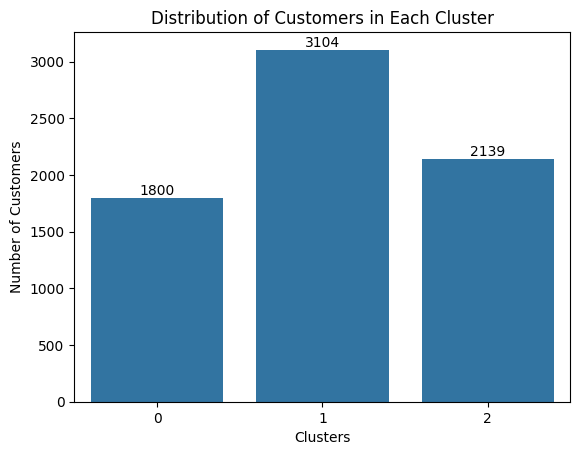

In [89]:
# create a bar chart for each cluster
ax = sns.countplot(data=clustering, x='Cluster')
ax.bar_label(ax.containers[0])

# add a title and labels for the x and y axes
plt.title('Distribution of Customers in Each Cluster')
plt.xlabel('Clusters')
plt.ylabel('Number of Customers')

# show the plot
plt.show()

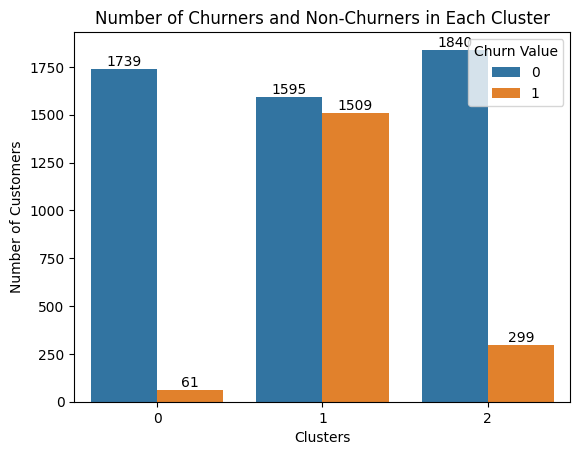

In [90]:
# create a bar chart for each cluster by churn
ax = sns.countplot(data=clustering, x='Cluster', hue='Churn Value')

# add labels to the bars
for i in ax.containers:
  ax.bar_label(i,)

# add a title and labels for the x and y axes
plt.title('Number of Churners and Non-Churners in Each Cluster')
plt.xlabel('Clusters')
plt.ylabel('Number of Customers')

# show the plot
plt.show()

Observation:

*   The clustering analysis reveals distinct patterns in customer behavior across the three clusters. Cluster 0 represents a largely loyal customer base, Cluster 1 shows a critical balance that could shift either way, and Cluster 2, while mainly composed of non-churners, has a significant number of churners that need attention. Tailored strategies should be implemented for each cluster to optimize retention and reduce churn, with a particular focus on converting potential churners in Cluster 1 and addressing specific issues in Cluster 2. Understanding the unique characteristics and needs of each cluster will be key to improving overall customer retention and satisfaction.

#### **Task 5.1.3 Evaluate Results**

In [98]:
# Define aggregation functions for numerical and categorical columns
agg_funcs = {col: ['mean', 'median', 'std'] for col in num}
agg_funcs.update({col: lambda x: x.value_counts().index[0] for col in cat})

# Profile each cluster
cluster_profiles = clustering.groupby('Cluster').agg(agg_funcs)

# Print the cluster profiles
cluster_profiles

Satisfaction Score                  Number of Referrals         \
                      mean median       std                mean median   
Cluster                                                                  
0                 3.966667    4.0  0.847453            2.703333    1.0   
1                 2.733247    3.0  1.263423            0.721972    0.0   
2                 3.380084    3.0  0.999062            3.104254    1.0   

                  Tenure in Months                    \
              std             mean median        std   
Cluster                                                
0        3.417867        31.851667   28.0  23.240285   
1        1.766690        15.176224   11.0  14.266609   
2        3.362685        57.812062   61.0  12.528330   

        Avg Monthly Long Distance Charges  ... Premium Tech Support  \
                                     mean  ...             <lambda>   
Cluster                                    ...                        
0                               23.534694  ...                   No   
1                               20.234468  ...                   No   
2                               26.428083  ...                  Yes   

        Streaming TV Streaming Movies Streaming Music Unlimited Data  \
            <lambda>         <lambda>        <lambda>       <lambda>   
Cluster                                                                
0                 No               No              No             No   
1                 No               No              No            Yes   
2                Yes              Yes             Yes            Yes   

               Contract Paperless Billing   Payment Method  Married   Region  
               <lambda>          <lambda>         <lambda> <lambda> <lambda>  
Cluster                                                                       
0              Two Year                No      Credit Card      Yes        5  
1        Month-to-Month               Yes  Bank Withdrawal       No        5  
2              Two Year               Yes  Bank Withdrawal      Yes        5  

[3 rows x 55 columns]

##### **Task 5.1.3.1 Analysing Categorical Variables by Clusters**

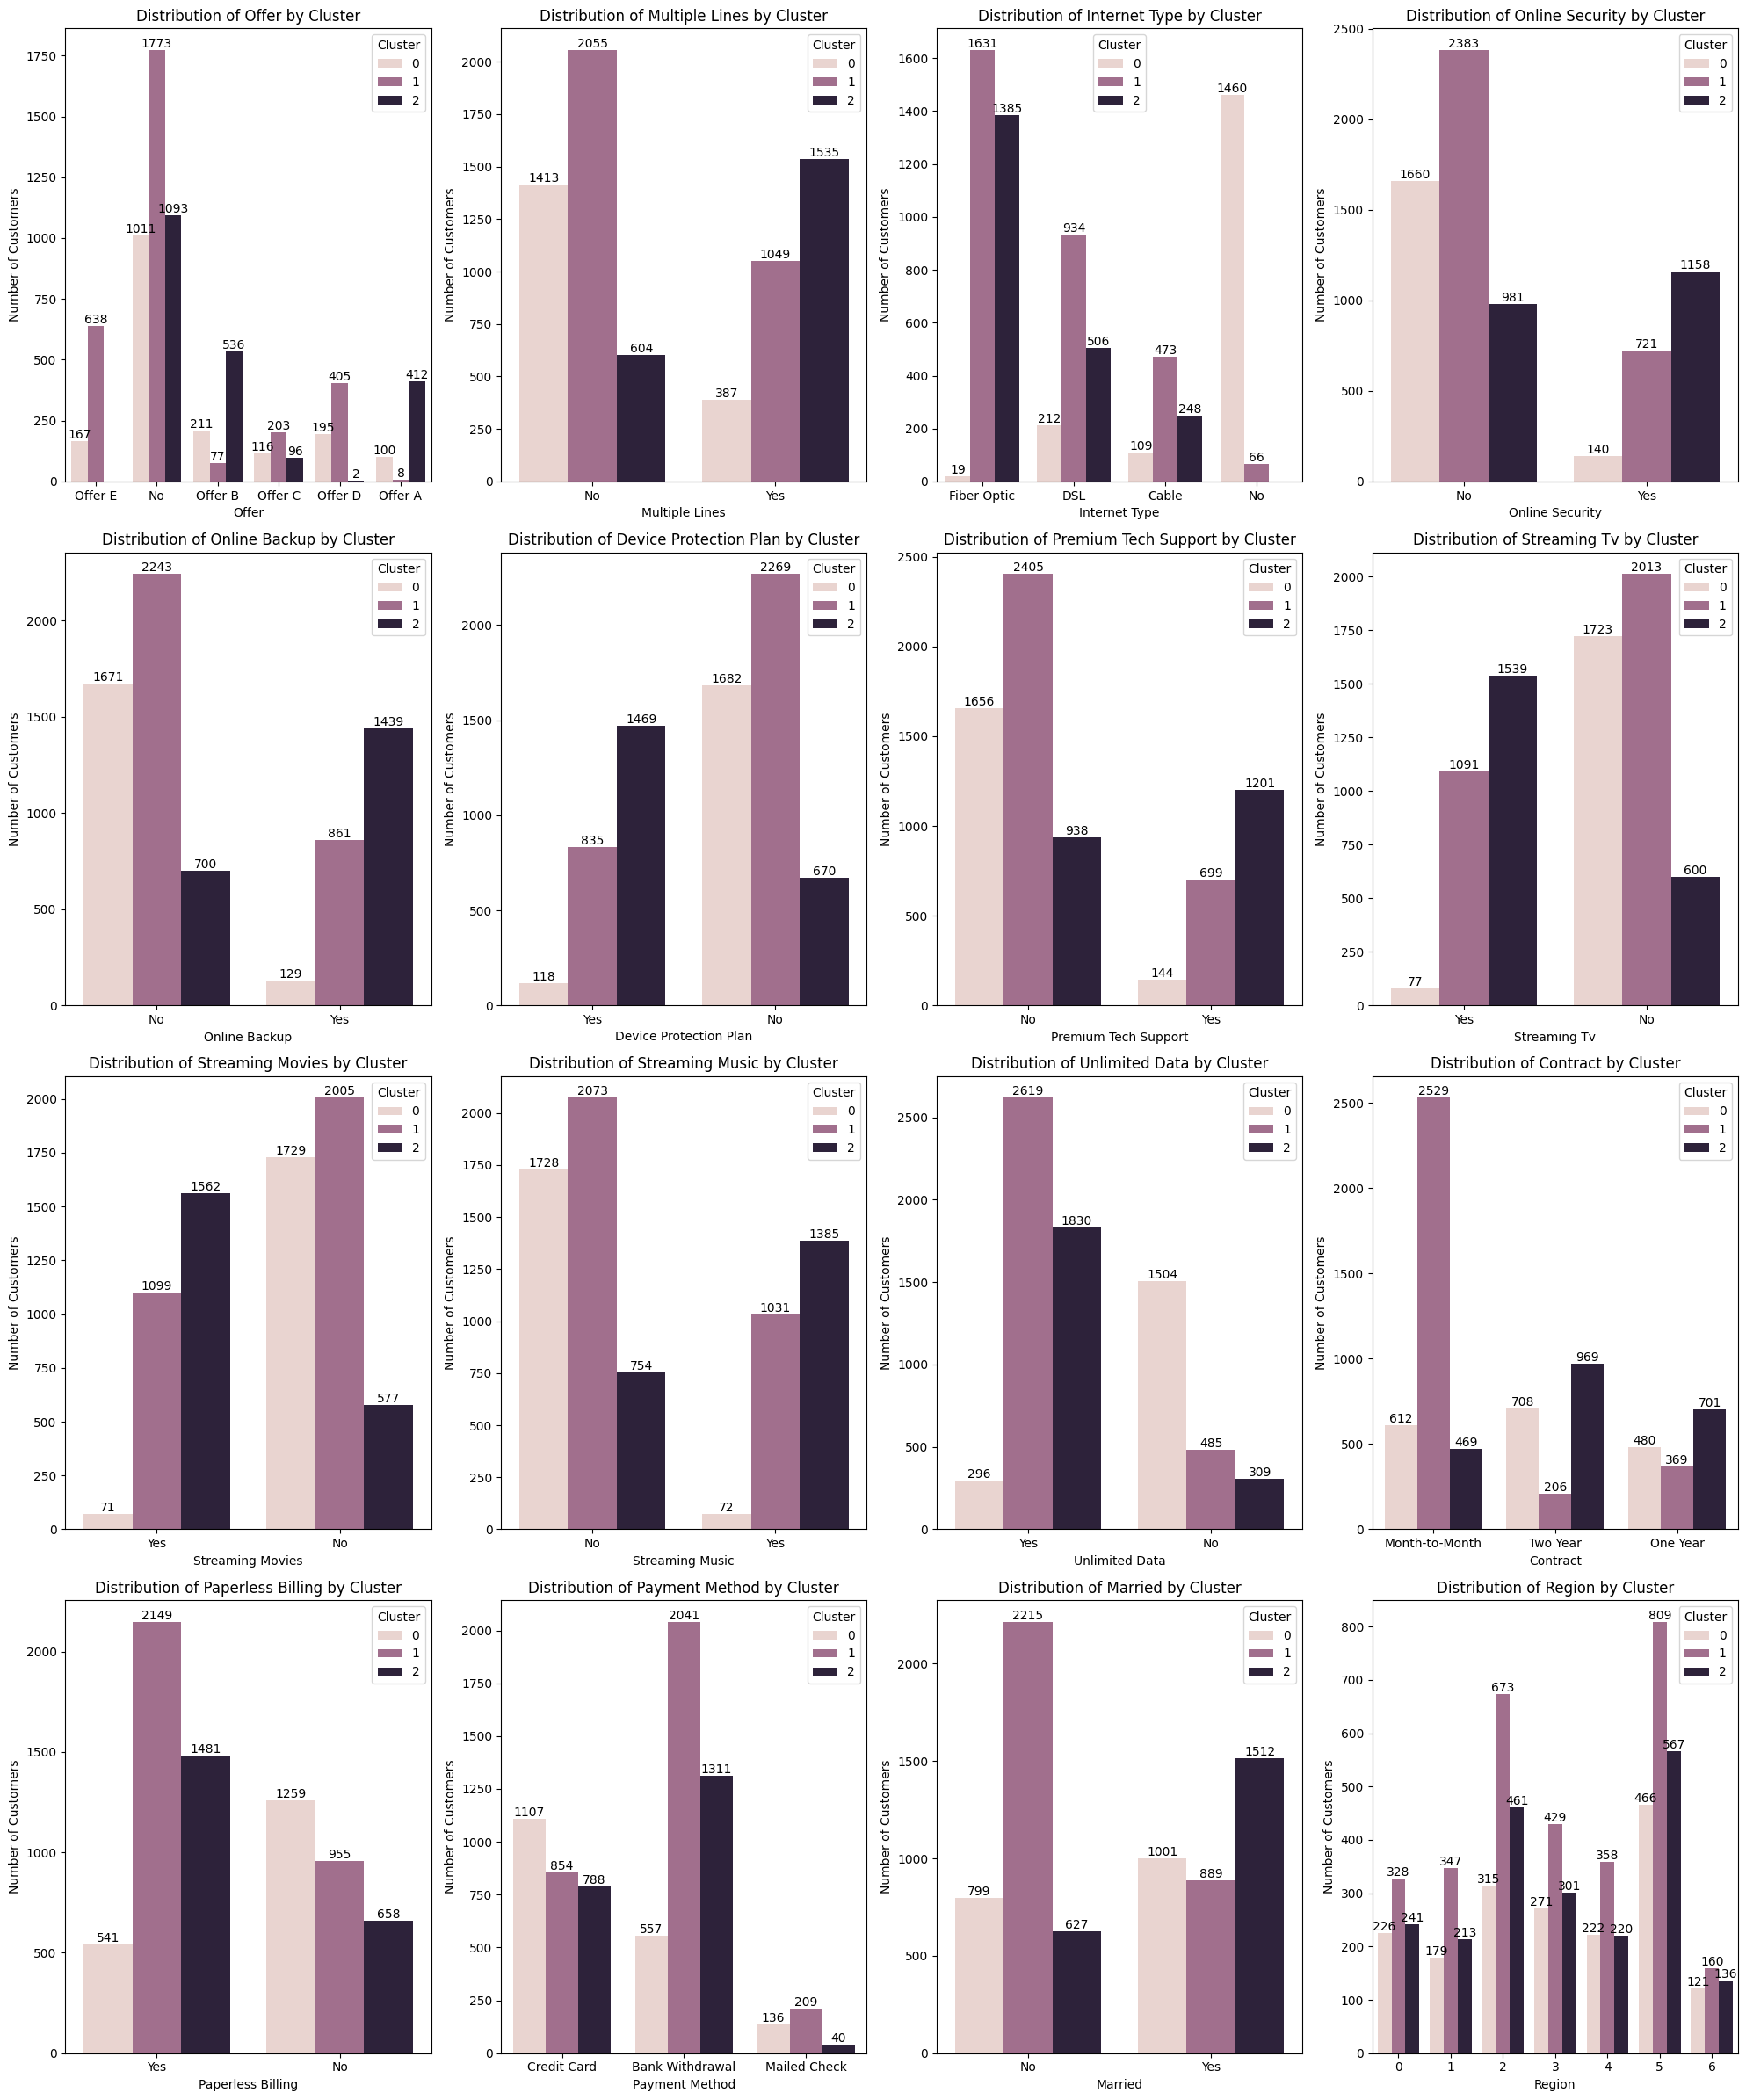

In [106]:
# Calculate the number of rows and columns needed for the subplots
n_rows = int(np.ceil(len(cat) / 4))
n_cols = 4

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 24))

# Flatten the array of subplots into a list
axs = axs.flatten()

# Create a bar chart for each categorical column
for i, col in enumerate(cat):
    ax = sns.countplot(data=clustering, x=col, hue='Cluster', ax=axs[i])
    for i in ax.containers:
      ax.bar_label(i,)

# Add a title and labels for the x and y axes
for i, ax in enumerate(axs):
    if i < len(cat):
      ax.set_title('Distribution of ' + str(cat[i].title()) + ' by Cluster')
      ax.set_xlabel(cat[i].title())
    ax.set_ylabel('Number of Customers')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

##### **Task 5.1.3.2 Analysing Numeric Variables by Clusters**

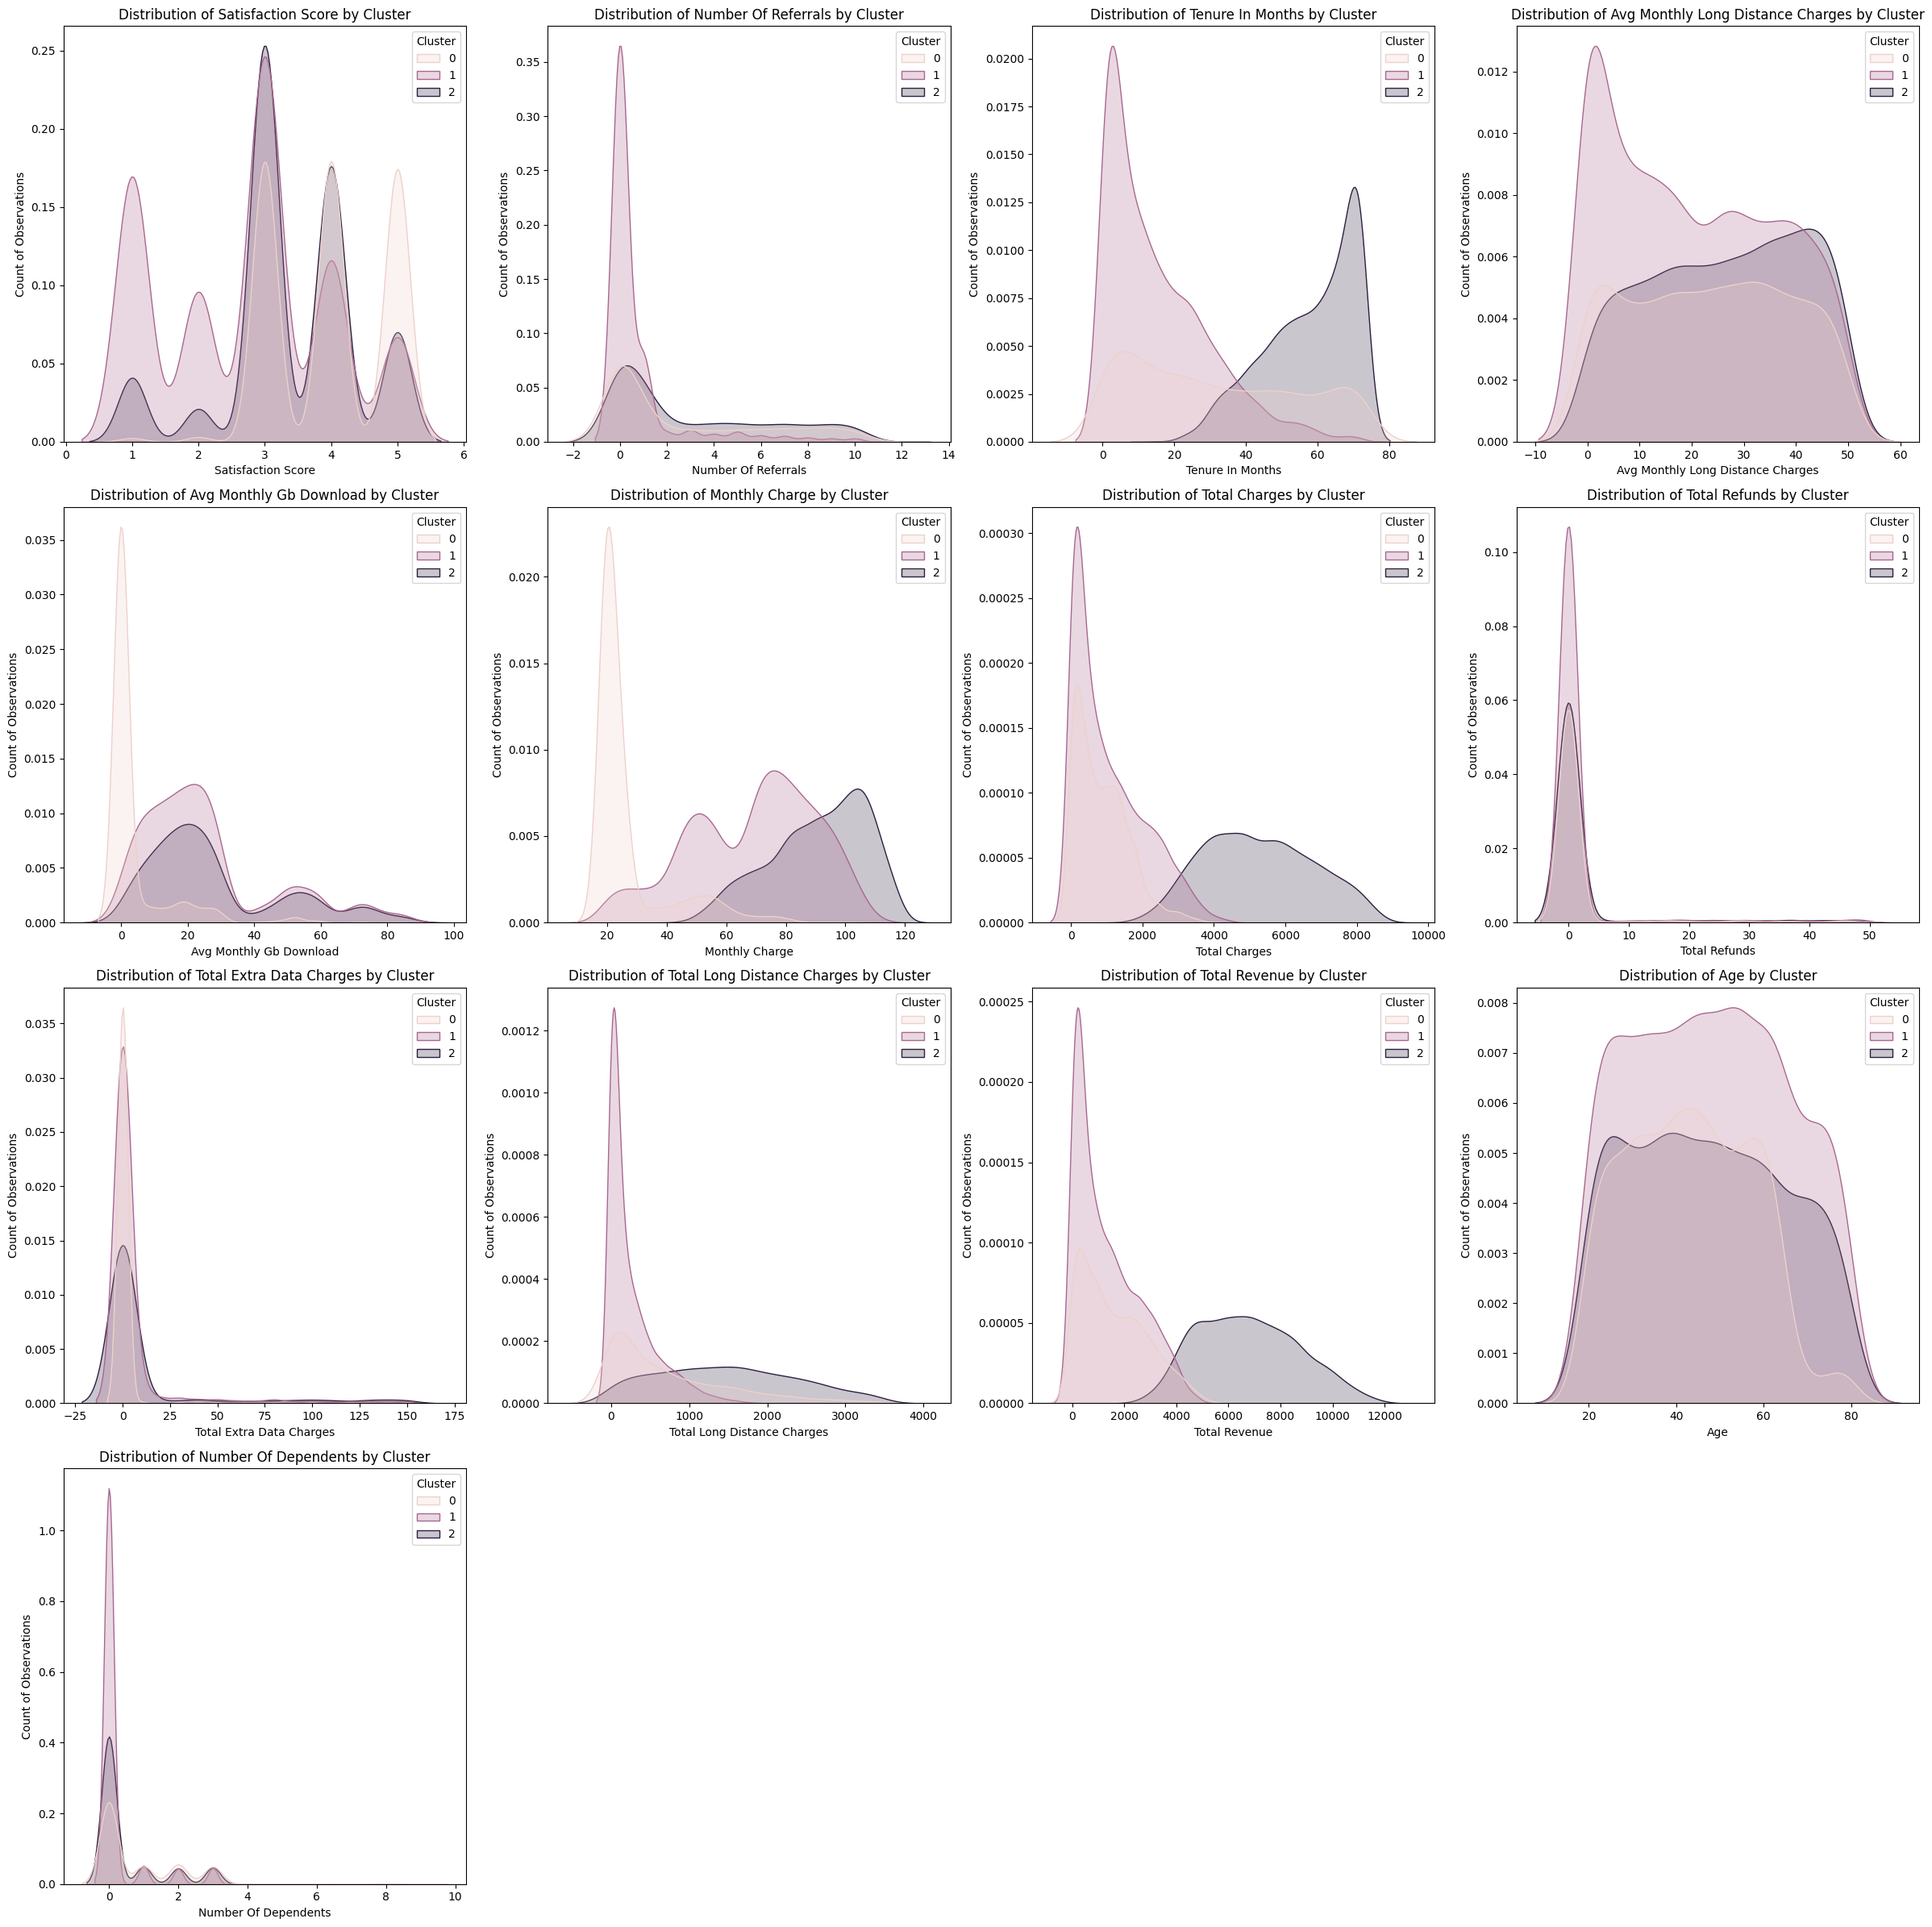

In [105]:
# Set the figure size
plt.figure(figsize=(24, 24))

# Loop over the columns and create a kde for each one
for i, col in enumerate(num):
    plt.subplot(4, 4, i+1)
    sns.kdeplot(data=clustering, x=col, hue='Cluster', fill=True)
    plt.title('Distribution of ' + str(num[i].title()) + ' by Cluster')
    plt.xlabel(str(num[i].title()))
    plt.ylabel('Count of Observations')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

### Task 5.2: Classification - Predicting Churn Likelihood for Individual Customer

#### Task 5.2.1 Modeling Technique Selection

In [200]:
# Make a copy of df's indices and data
classification = df.copy(deep=True)

In [201]:
# Separate the predictors and the labels
X = classification.drop('Churn Value', axis=1)
y = classification['Churn Value'].copy()

In [202]:
# Create the preprocessing pipelines for both numeric and categorical data using selectors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_include=np.number)),  # Transform numerical columns
        ('cat', OneHotEncoder(), make_column_selector(dtype_include=object))  # Transform categorical columns
    ]
)

In [203]:
# Define the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianProcessClassifier': GaussianProcessClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

In [204]:
# Split the given features and the target array into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [147]:
# # Preprocess the training data
# X_train_preprocessed = preprocessor.fit_transform(X_train)
# X_test_preprocessed = preprocessor.transform(X_test)

In [148]:
# # Apply SMOTE to the preprocessed training data
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

#### Task 5.2.2 Building the Model

In [205]:
# Train the model
def train_model(model, X_train, y_train, use_smote=False):
    if use_smote:
        pipeline = ImbPipeline(steps=[
            ("preprocessor", preprocessor),
            ("smote", SMOTE(random_state=42)),
            ("classifier", model)
        ])
    else:
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])

    # Measure training time and memory usage
    start_time = time.time()
    mem_usage_start = memory_usage(-1, interval=0.1, timeout=1)[0]

    # Train the classifier
    pipeline.fit(X_train, y_train)

    mem_usage_end = memory_usage(-1, interval=0.1, timeout=1)[0]
    end_time = time.time()

    training_time = end_time - start_time
    memory_used = mem_usage_end - mem_usage_start

    return pipeline, training_time, memory_used

# # Train the model
# def train_model(model, X_train, y_train, use_smote=False):
#     if use_smote:
#         # Use SMOTE preprocessed data
#         X = X_train_smote
#         y = y_train_smote
#     else:
#         # Use original preprocessed data
#         X = X_train_preprocessed
#         y = y_train

#     pipeline = Pipeline(steps=[
#         ("classifier", model)
#     ])

#     # Measure training time and memory usage
#     start_time = time.time()
#     mem_usage_start = memory_usage(-1, interval=0.1, timeout=1)[0]

#     # Train the classifier
#     pipeline.fit(X, y)

#     mem_usage_end = memory_usage(-1, interval=0.1, timeout=1)[0]
#     end_time = time.time()

#     training_time = end_time - start_time
#     memory_used = mem_usage_end - mem_usage_start

#     return pipeline, training_time, memory_used

## Task 6: Evaluation

### Task 6.1: Evaluating the Results

In [206]:
# Evaluate the model
def evaluate_model(model_name, pipeline, X_train, y_train, X_test, y_test, training_time, memory_used):
    # Measure inference time and memory usage
    start_time_inference = time.time()
    mem_usage_start_inference = memory_usage(-1, interval=0.1, timeout=1)[0]

    # Make predictions on test set
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    # y_test_proba = pipeline.predict_proba(X_test)[:, 1]

    end_time_inference = time.time()
    mem_usage_end_inference = memory_usage(-1, interval=0.1, timeout=1)[0]

    inference_time = end_time_inference - start_time_inference
    memory_used_inference = mem_usage_end_inference - mem_usage_start_inference

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    matrix = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = matrix.ravel()
    report = classification_report(y_test, y_test_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

    # Collect results
    result = {
        "Model": model_name,
        "Train Accuracy": round(train_accuracy, 3),
        "Test Accuracy": round(test_accuracy, 3),
        "Precision_0": round(report["0"]["precision"], 3),
        "Recall_0": round(report["0"]["recall"], 3),
        "F1_0": round(report["0"]["f1-score"], 3),
        "Precision_1": round(report["1"]["precision"], 3),
        "Recall_1": round(report["1"]["recall"], 3),
        "F1_1": round(report["1"]["f1-score"], 3),
        "Overall Accuracy": round(report["accuracy"], 3),
        "True Positive": tp,
        "True Negative": tn,
        "False Positive": fp,
        "False Negative": fn,
        "ROC AUC": round(roc_auc, 3),
        "Training Time (s)": round(training_time, 3),
        "Memory Used (MB)": round(memory_used, 3),
        "Inference Time (s)": round(inference_time, 3),
        "Memory Used Inference (MB)": round(memory_used_inference, 3)
    }

    return result

In [207]:
# Create lists to store the results for original and SMOTE datasets
results_list_original = []
results_list_smote = []

# Train and evaluate each classifier on both the original and SMOTE-balanced datasets
for name, clf in classifiers.items():
    # Train the model
    pipeline_original, training_time_original, memory_used_original = train_model(clf, X_train, y_train, use_smote=False)
    pipeline_smote, training_time_smote, memory_used_smote = train_model(clf, X_train, y_train, use_smote=True)

    # Save the trained models
    joblib.dump(pipeline_original, f'/drive/My Drive/Master of Data Science/Semester 2/WQD7005/{name}_original.joblib')
    joblib.dump(pipeline_smote, f'/drive/My Drive/Master of Data Science/Semester 2/WQD7005/{name}_smote.joblib')

    # Evaluate the model
    result_original = evaluate_model(name, pipeline_original, X_train, y_train, X_test, y_test, training_time_original, memory_used_original)
    result_smote = evaluate_model(name, pipeline_smote, X_train, y_train, X_test, y_test, training_time_smote, memory_used_smote)

    # Append results to the respective lists
    results_list_original.append(result_original)
    results_list_smote.append(result_smote)

# Convert results to DataFrames
results_df_original = pd.DataFrame(results_list_original)
results_df_smote = pd.DataFrame(results_list_smote)


# # Create lists to store the results for original and SMOTE datasets
# results_list_original = []
# results_list_smote = []

# # Train and evaluate each classifier on both the original and SMOTE-balanced datasets
# for name, clf in classifiers.items():
#     # Train the model
#     pipeline_original, training_time_original, memory_used_original = train_model(clf, X_train, y_train, use_smote=False)
#     pipeline_smote, training_time_smote, memory_used_smote = train_model(clf, X_train, y_train, use_smote=True)

#     # Evaluate the model
#     result_original = evaluate_model(name, pipeline_original, X_train_preprocessed, y_train, X_test_preprocessed, y_test, training_time_original, memory_used_original)
#     result_smote = evaluate_model(name, pipeline_smote, X_train_smote, y_train_smote, X_test_preprocessed, y_test, training_time_smote, memory_used_smote)

#     # Append results to the respective lists
#     results_list_original.append(result_original)
#     results_list_smote.append(result_smote)

In [184]:
# # Convert results to DataFrames
# results_df_original = pd.DataFrame(results_list_original)
# results_df_smote = pd.DataFrame(results_list_smote)

#### Task 6.1.1: Baseline Dataset

In [185]:
# Display results
results_df_original

,Model,Train Accuracy,Test Accuracy,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Overall Accuracy,True Positive,True Negative,False Positive,False Negative,ROC AUC,Training Time (s),Memory Used (MB),Inference Time (s),Memory Used Inference (MB)
0,Logistic Regression,0.957,0.944,0.982,0.941,0.961,0.854,0.952,0.900,0.944,356,974,61,18,0.990,2.316,0.000,1.007,0.000
1,KNeighborsClassifier,0.922,0.853,0.966,0.829,0.892,0.660,0.920,0.769,0.853,344,858,177,30,0.941,2.015,0.000,2.232,0.000
2,GaussianProcessClassifier,0.994,0.901,0.975,0.889,0.930,0.753,0.936,0.834,0.901,350,920,115,24,0.950,68.696,242.176,4.079,0.242
3,GaussianNB,0.840,0.833,0.940,0.826,0.879,0.639,0.853,0.731,0.833,319,855,180,55,0.918,2.019,0.000,1.013,0.000
4,Decision Tree,1.000,0.953,0.973,0.963,0.968,0.901,0.925,0.913,0.953,346,997,38,28,0.944,2.047,0.000,1.008,0.000
5,Random Forest,1.000,0.963,0.969,0.982,0.975,0.947,0.912,0.929,0.963,341,1016,19,33,0.985,2.896,0.000,1.200,0.000


In [211]:
# Save the results DataFrame to a CSV file
results_df_original.to_csv('/drive/My Drive/Master of Data Science/Semester 2/WQD7005/results_original.csv', index=False)

#### Task 6.1.1: SMOTE Dataset

In [186]:
# Display results
results_df_smote

,Model,Train Accuracy,Test Accuracy,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Overall Accuracy,True Positive,True Negative,False Positive,False Negative,ROC AUC,Training Time (s),Memory Used (MB),Inference Time (s),Memory Used Inference (MB)
0,Logistic Regression,0.963,0.944,0.982,0.941,0.961,0.854,0.952,0.900,0.944,356,974,61,18,0.990,2.571,0.000,1.007,0.000
1,KNeighborsClassifier,0.946,0.853,0.966,0.829,0.892,0.660,0.920,0.769,0.853,344,858,177,30,0.941,2.014,0.000,2.111,0.000
2,GaussianProcessClassifier,0.996,0.901,0.975,0.889,0.930,0.753,0.936,0.834,0.901,350,920,115,24,0.950,203.500,280.633,5.273,0.000
3,GaussianNB,0.854,0.833,0.940,0.826,0.879,0.639,0.853,0.731,0.833,319,855,180,55,0.918,2.020,0.000,1.018,0.000
4,Decision Tree,1.000,0.953,0.973,0.963,0.968,0.901,0.925,0.913,0.953,346,997,38,28,0.944,2.086,0.000,1.008,0.000
5,Random Forest,1.000,0.963,0.969,0.982,0.975,0.947,0.912,0.929,0.963,341,1016,19,33,0.985,3.518,0.000,1.190,0.258


In [212]:
# Save the results DataFrame to a CSV file
results_df_smote.to_csv('/drive/My Drive/Master of Data Science/Semester 2/WQD7005/results_smote.csv', index=False)

### Task 6.2: Review Process

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'liblinear', 'saga'],
    'classifier__max_iter': [100, 200, 500, 1000]
}

# Create a pipeline for Logistic Regression with hyperparameter tuning
pipeline_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42))
])

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the model with Grid Search
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

In [ ]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)

result_best_model = evaluate_model("Best Logistic Regression Model", best_model, X_train, y_train, X_test, y_test, 0, 0)  # Training time and memory usage are not relevant here
result_best_model

In [ ]:
# /drive/My Drive/Master of Data Science/Semester 2/WQD7005/

# Save the preprocessor pipeline and the best model
joblib.dump(preprocessor, base_dir+'preprocessor_pipeline.pkl')
joblib.dump(best_model, base_dir'best_model.pkl')

['/drive/My Drive/Master of Data Science/Semester 2/WQD7005/best_model.pkl']